In [1]:
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

True

In [2]:
import os.path as osp
import numpy as np

from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

In [3]:
import os

# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

# embedding input and output
input_dim = 600
output_dim = 1

## 1. load training embeddings

In [4]:
Ntrain = 11896

"""
load from storage
"""
y_true = []
y_pred = []

for step in tqdm(range(Ntrain)):
    filename = osp.join("checkpoint", "trainingEmbeddings", "preds", "{}.npy".format(step))
    pred_np = np.load(filename)
    y_pred.extend(pred_np)
    
    filename = osp.join("checkpoint", "trainingEmbeddings", "labels", "{}.npy".format(step))
    label = np.load(filename)
    y_true.extend(label)

100%|███████████████████████████████████████████████████████████████████████████| 11896/11896 [00:19<00:00, 607.28it/s]


In [5]:
"""
combine embeddings
"""
Ndata = len(y_true)
dim = 600
graphEmbeddings = np.zeros((Ndata, dim))

# load separately as np.concatenate is too slow
for step in tqdm(range(Ntrain)):
    filename = osp.join("checkpoint", "trainingEmbeddings", "embeddings", "{}.npy".format(step))
    h_graph_np = np.load(filename)
    
    minVal = step*256
    maxVal = min((step+1)*256, Ndata)
    graphEmbeddings[minVal:maxVal, :] = h_graph_np

100%|███████████████████████████████████████████████████████████████████████████| 11896/11896 [00:47<00:00, 248.42it/s]


In [6]:
"""
evaluate
"""
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
evaluator.eval(input_dict)["mae"]

0.10943220555782318

In [7]:
"""
prepare training data
"""
x_train = graphEmbeddings
y_train = np.expand_dims(np.array(y_true), axis=-1)

x_train.shape

(3045360, 600)

### 2. define, train BNN and save models

In [8]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5 * (target - output)**2 / sigma**2
    log_coeff = - no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
#     log_coeff = - no_dim * torch.log(sigma + 1e-12) - 0.5 * no_dim * np.log(2 * np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)

In [9]:
# """
# prior distribution
# """
# class gaussian:
#     def __init__(self, mu, sigma):
#         self.mu = mu
#         self.sigma = sigma

#     def loglik(self, weights):
#         exponent = -0.5*(weights - self.mu)**2 / self.sigma**2
#         log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))

#         return (exponent + log_coeff).sum()
    
# """
# BBP Layer
# """
# class BayesLinear_Normalq(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, prior):
#         super(BayesLinear_Normalq, self).__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.prior = prior
        
#         scale = (2/self.input_dim)**0.5
#         rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
#         self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
#         self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
#         self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
#         self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
#         self.activation = nn.ReLU()
        
#     def forward(self, x, sample = True):
        
#         if sample:
#             # sample gaussian noise for each weight and each bias
#             weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
#             bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
#             # calculate the weight and bias stds from the rho parameters
#             weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
#             bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
#             # calculate samples from the posterior from the sampled noise and mus/stds
#             weight_sample = self.weight_mus + weight_epsilons*weight_stds
#             bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
#             output = torch.mm(x, weight_sample) + bias_sample
            
#             # force positive
#             output = self.activation(output)
            
#             # computing the KL loss term
#             prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
#             KL_loss = 0.5*(torch.log(prior_cov/varpost_cov + 1e-12)).sum() - 0.5*weight_stds.numel()
#             KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
#             KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
#             prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
#             KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov + 1e-12)).sum() - 0.5*bias_stds.numel()
#             KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
#             KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
#             return output, KL_loss
        
#         else:
#             output = torch.mm(x, self.weight_mus) + self.bias_mus
#             # force positive
#             output = self.activation(output)

#             return output, KL_loss
        
#     def sample_layer(self, no_samples):
#         all_samples = []
#         for i in range(no_samples):
#             # sample gaussian noise for each weight and each bias
#             weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
#             # calculate the weight and bias stds from the rho parameters
#             weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
#             # calculate samples from the posterior from the sampled noise and mus/stds
#             weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
#             all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
#         return all_samples
    
    
# class BBP_Heteroscedastic_Model(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, num_units, learn_rate, batch_size, no_batches):
#         super(BBP_Heteroscedastic_Model, self).__init__()

#         self.input_dim = input_dim
#         self.output_dim = output_dim

#         self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
#         self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))

#         self.activation = nn.ReLU(inplace=True)

#         self.learn_rate = learn_rate
#         self.batch_size = batch_size
#         self.no_batches = no_batches

#         self.optimizer = torch.optim.Adam(self.parameters(), lr = self.learn_rate)
#         self.loss_func = log_gaussian_loss
        
#     def forward(self, x):
#         KL_loss_total = 0
#         x = x.view(-1, self.input_dim)

#         # seems like every layer outputs new vector and loss
#         x, KL_loss = self.layer1(x)
#         KL_loss_total = KL_loss_total + KL_loss
#         x = self.activation(x)

#         x, KL_loss = self.layer2(x)
#         KL_loss_total = KL_loss_total + KL_loss
        
#         # positive only output
#         x = self.activation(x)

#         return x, KL_loss_total
    
#     def fit(self, x, y, no_samples):
#         x, y = to_variable(var=(x, y), cuda=True)
        
#         # reset gradient and total loss
#         self.optimizer.zero_grad()
#         fit_loss_total = 0
        
#         for i in range(no_samples):
#             output, KL_loss_total = self.forward(x)

#             # calculate fit loss based on mean and standard deviation of output
#             fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
#             fit_loss_total = fit_loss_total + fit_loss
        
#         KL_loss_total = KL_loss_total/self.no_batches
#         total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
#         total_loss.backward()
#         self.optimizer.step()

#         return fit_loss_total/no_samples, KL_loss_total


In [39]:
def KLD_cost(mu_p, sig_p, mu_q, sig_q):
    KLD = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    # https://arxiv.org/abs/1312.6114 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #print(2 * torch.log(sig_p / sig_q).sum())
    #print(((sig_q / sig_p).pow(2)).sum())
    #print((((mu_p - mu_q) / sig_p).pow(2)).sum())
    return KLD


class BayesLinear(nn.Module):
    
    """
    Linear Layer where activations are sampled from a fully factorised normal which is given by aggregating
    the moments of each weight's normal distribution. The KL divergence is obtained in closed form. Only works
    with gaussian priors.
    """
    
    def __init__(self, n_in, n_out, prior_sig, bias = True):
        
        super(BayesLinear, self).__init__()
        
        self.n_in = n_in
        self.n_out = n_out
        self.bias = bias
        self.prior_sig = prior_sig
        
        # initialise mu for weights
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.02, 0.02))
        
        # initialise mu for biases
        if self.bias:
            self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.02, 0.02))

            
    def init_rho(self, p_min, p_max):
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(p_min, p_max))
        if self.bias:
            self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(p_min, p_max))     


    def forward(self, X, sample=False):
        
        if sample:

            ### weights
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20) # compute stds for weights
            act_W_mu = torch.mm(X, self.W_mu)  # activation means
            act_W_std = torch.sqrt(torch.clamp_min(torch.mm(X.pow(2), std_w.pow(2)),1e-6)) # actiavtion stds
            
            eps_W = Variable(self.W_mu.data.new(act_W_std.size()).normal_(mean=0, std=1)) # draw samples from 0,1 gaussian
            act_W_out = act_W_mu + act_W_std * eps_W # sample weights from 'posterior'
            
            output = act_W_out
            kld = KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.W_mu, sig_q=std_w)
            
            if self.bias:
                
                std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20) # compute stds for biases
                eps_b = Variable(self.b_mu.data.new(std_b.size()).normal_(mean=0, std=1)) # draw samples from 0,1 gaussian
                act_b_out = self.b_mu + std_b * eps_b # sample biases from 'posterior'
                output += act_b_out.unsqueeze(0).expand(X.shape[0], -1)
                kld += KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.b_mu, sig_q=std_b)
       
            return output, kld
        
        
        else:
            
            output = torch.mm(X, self.W_mu)
            
            # kld is just standard regularisation term
            kld = (0.5*((self.W_mu / self.prior_sig).pow(2))+torch.log(self.prior_sig*torch.sqrt(torch.tensor(2*np.pi)))).sum()
            
            if self.bias:
                output += self.b_mu.expand(X.size()[0], self.n_out)
                
                kld += (0.5*((self.b_mu / self.prior_sig).pow(2))+torch.log(self.prior_sig*torch.sqrt(torch.tensor(2*np.pi)))).sum()
            
            
            return output, kld

In [40]:
class ModelBBP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelBBP, self).__init__()
#         self.prior_sig = 0.01
        
        self.input_dim = input_dim
        hidden_dim = 200
        self.output_dim = output_dim
        
        self.l1 = BayesLinear(n_in=self.input_dim, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l1.init_rho(-5.5, -1)
        self.l2a = BayesLinear(n_in=hidden_dim, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l2a.init_rho(-5.5, -1)
        self.l2b = BayesLinear(n_in=hidden_dim, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l2b.init_rho(-5.5, -1)
        self.l3 = BayesLinear(n_in=hidden_dim, n_out=self.output_dim, prior_sig=1, bias = True)
        self.l3.init_rho(-5.5, -1)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, X, sample=False):
        
        X, tkl = self.l1(X, sample)
        X = self.activation(X)

        X, kl = self.l2a(X, sample)
        X = self.activation(X)
        tkl += kl

        X, kl = self.l2b(X, sample)
        X = self.activation(X)
        tkl += kl
        
        X, kl = self.l3(X, sample)
#         X = self.activation(X)
        tkl += kl
        
        return X, tkl

## MAP

In [81]:
"""
Define MAP Model
"""
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, learn_rate, weight_decay):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(n_feature, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, 2*n_output)
        
        self.loss_func = log_gaussian_loss
#         self.optimizer = torch.optim.SGD(self.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        # added relu to avoid negative stddev
        x = F.relu(x)

#         # make sure prediction is positive
#         x[:, 0] = torch.clamp(x[:, 0], min=0)

        return x
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.forward(x)
#         loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)/x.shape[0]
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)/x.shape[0]
        
        # TRY TO ENFORCE L1 LOSS
        L1loss = torch.nn.L1Loss()(output[:, :1], y)
    
        loss.backward()
        self.optimizer.step()

#         return loss
        return L1loss

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

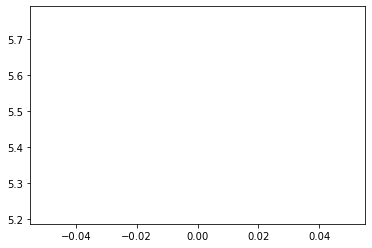

  2%|█▌                                                                          | 2000/100000 [00:27<22:51, 71.44it/s]

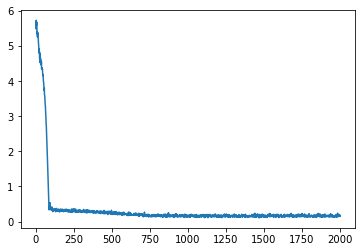

  4%|███                                                                         | 3996/100000 [00:56<22:51, 69.98it/s]

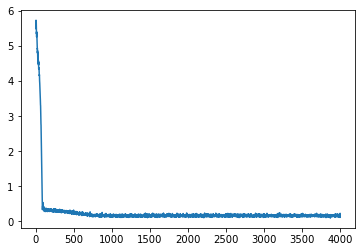

  6%|████▌                                                                       | 5996/100000 [01:25<22:25, 69.89it/s]

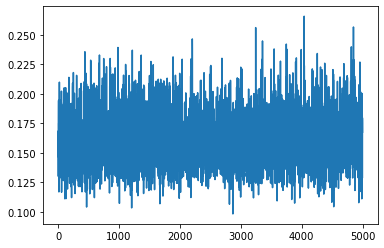

  8%|██████                                                                      | 7998/100000 [01:54<21:08, 72.55it/s]

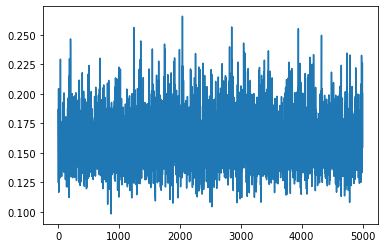

 10%|███████▌                                                                    | 9993/100000 [02:21<20:12, 74.23it/s]

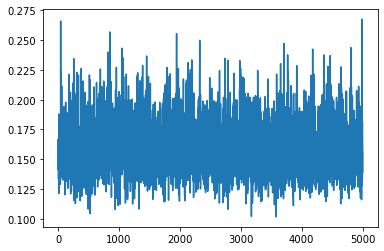

 12%|████████▉                                                                  | 11997/100000 [02:50<19:31, 75.14it/s]

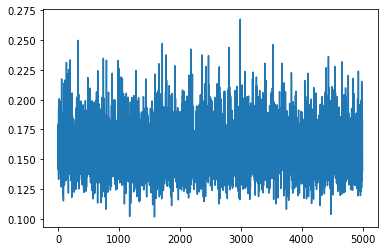

 14%|██████████▌                                                                | 14000/100000 [03:19<21:16, 67.38it/s]

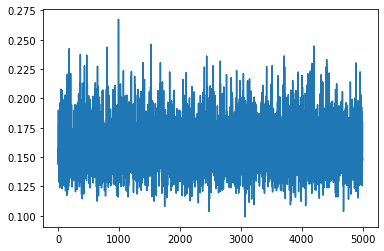

 16%|███████████▉                                                               | 15997/100000 [03:47<19:12, 72.90it/s]

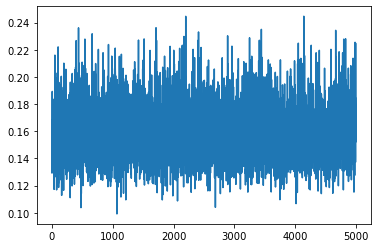

 18%|█████████████▍                                                             | 17995/100000 [04:15<18:38, 73.31it/s]

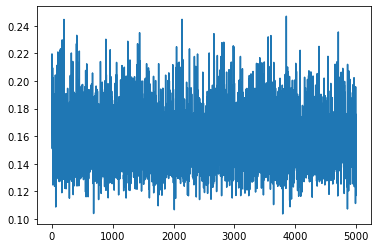

 20%|██████████████▉                                                            | 19996/100000 [04:43<18:03, 73.85it/s]

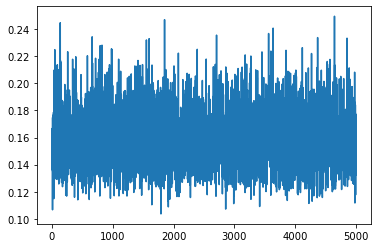

 22%|████████████████▍                                                          | 21994/100000 [05:10<18:01, 72.12it/s]

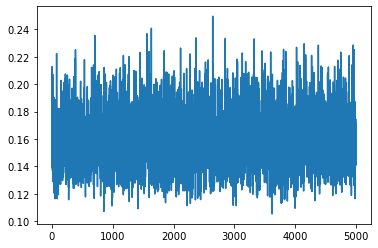

 24%|█████████████████▉                                                         | 23994/100000 [05:38<17:39, 71.71it/s]

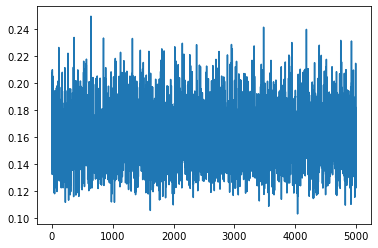

 26%|███████████████████▍                                                       | 25993/100000 [06:06<16:40, 73.98it/s]

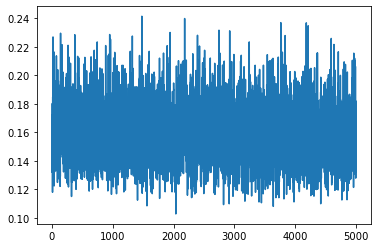

 28%|█████████████████████                                                      | 28000/100000 [06:34<16:49, 71.36it/s]

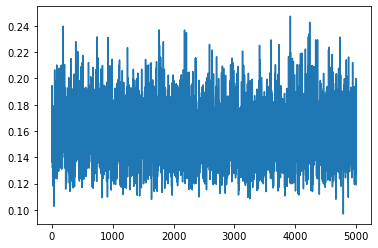

 30%|██████████████████████▍                                                    | 29998/100000 [07:01<16:22, 71.23it/s]

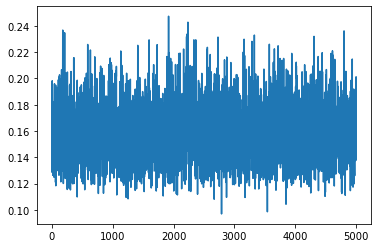

 32%|███████████████████████▉                                                   | 31998/100000 [07:29<16:18, 69.51it/s]

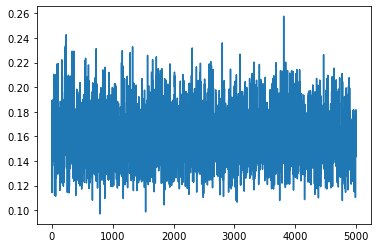

 34%|█████████████████████████▍                                                 | 33994/100000 [07:56<15:04, 73.00it/s]

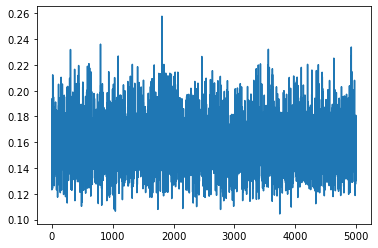

 36%|███████████████████████████                                                | 36000/100000 [08:24<15:20, 69.50it/s]

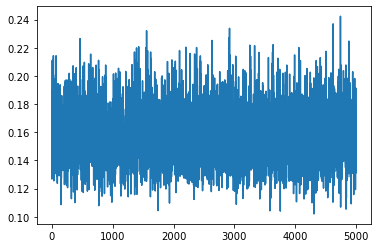

 38%|████████████████████████████▍                                              | 37999/100000 [08:52<14:39, 70.49it/s]

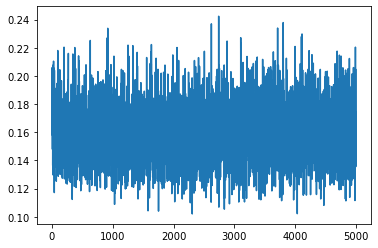

 40%|█████████████████████████████▉                                             | 39995/100000 [09:20<14:14, 70.20it/s]

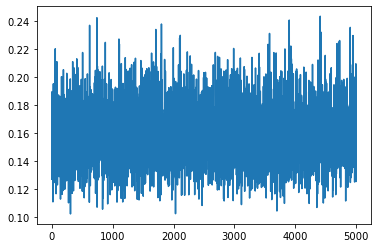

 42%|███████████████████████████████▍                                           | 41993/100000 [09:48<13:40, 70.70it/s]

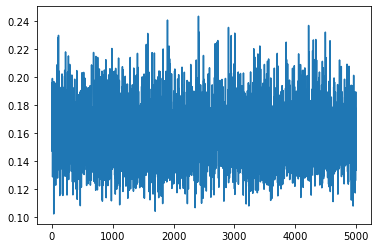

 44%|████████████████████████████████▉                                          | 43994/100000 [10:16<12:27, 74.95it/s]

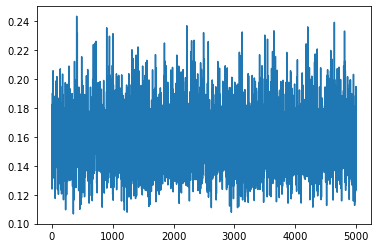

 46%|██████████████████████████████████▍                                        | 45999/100000 [10:43<12:05, 74.39it/s]

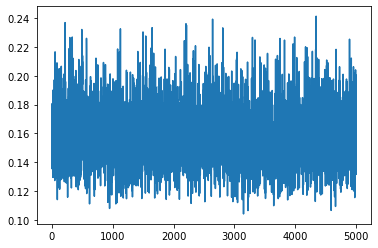

 48%|███████████████████████████████████▉                                       | 47998/100000 [11:11<11:51, 73.11it/s]

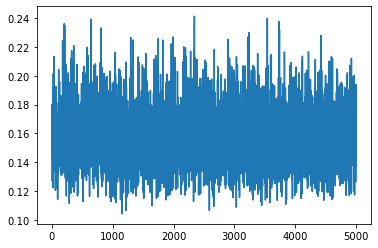

 50%|█████████████████████████████████████▍                                     | 49992/100000 [11:39<10:51, 76.71it/s]

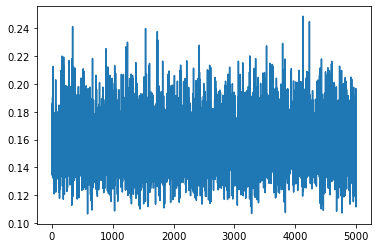

 52%|██████████████████████████████████████▉                                    | 51994/100000 [12:06<11:41, 68.41it/s]

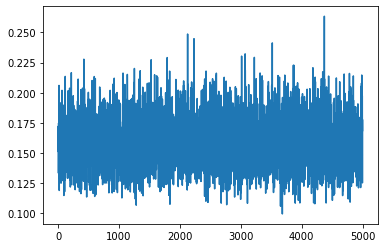

 54%|████████████████████████████████████████▍                                  | 53997/100000 [12:37<10:11, 75.27it/s]

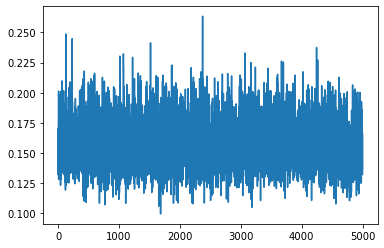

 56%|██████████████████████████████████████████                                 | 56000/100000 [13:07<10:40, 68.73it/s]

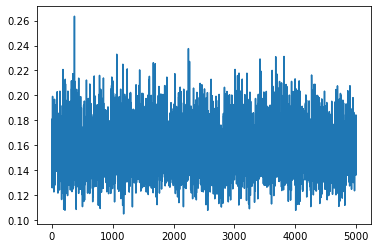

 58%|███████████████████████████████████████████▍                               | 57996/100000 [13:37<09:52, 70.88it/s]

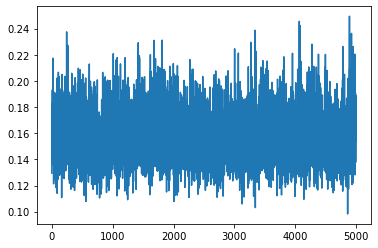

 60%|████████████████████████████████████████████▉                              | 59999/100000 [14:07<09:26, 70.61it/s]

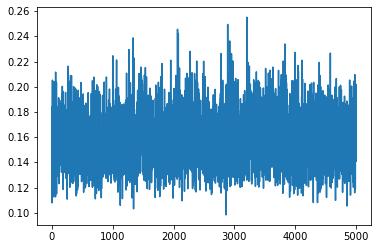

 62%|██████████████████████████████████████████████▍                            | 61994/100000 [14:36<08:42, 72.73it/s]

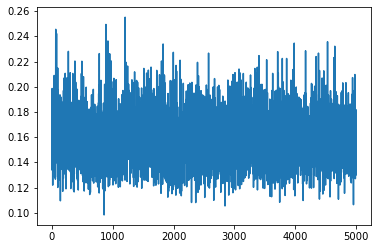

 64%|███████████████████████████████████████████████▉                           | 63996/100000 [15:03<08:02, 74.63it/s]

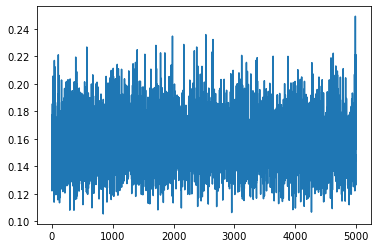

 66%|█████████████████████████████████████████████████▍                         | 65998/100000 [15:31<07:45, 73.03it/s]

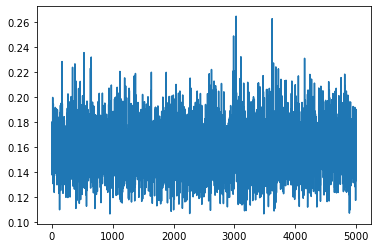

 68%|██████████████████████████████████████████████████▉                        | 67993/100000 [15:58<07:12, 74.03it/s]

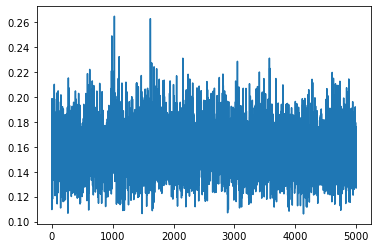

 70%|████████████████████████████████████████████████████▍                      | 69999/100000 [16:26<06:38, 75.34it/s]

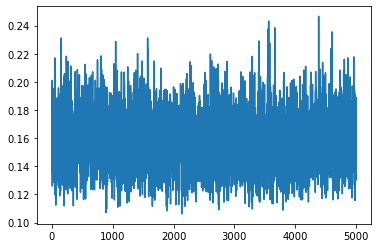

 72%|█████████████████████████████████████████████████████▉                     | 71998/100000 [16:53<06:58, 66.99it/s]

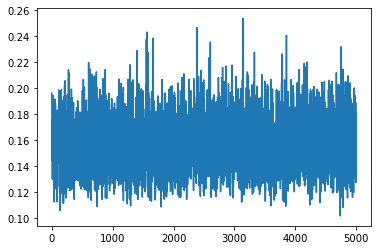

 74%|███████████████████████████████████████████████████████▍                   | 73996/100000 [17:21<05:54, 73.25it/s]

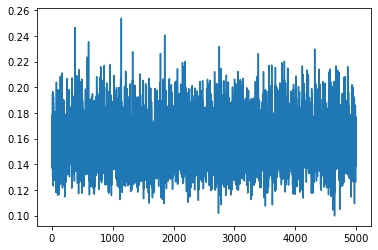

 76%|████████████████████████████████████████████████████████▉                  | 75998/100000 [17:49<05:26, 73.43it/s]

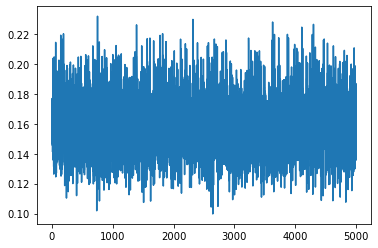

 78%|██████████████████████████████████████████████████████████▍                | 77998/100000 [18:17<05:17, 69.25it/s]

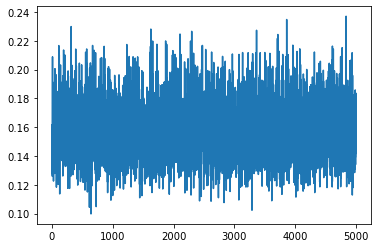

 80%|███████████████████████████████████████████████████████████▉               | 79997/100000 [18:45<04:30, 73.88it/s]

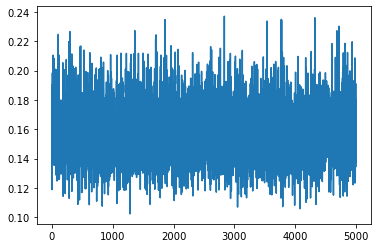

 82%|█████████████████████████████████████████████████████████████▍             | 82000/100000 [19:13<04:03, 73.81it/s]

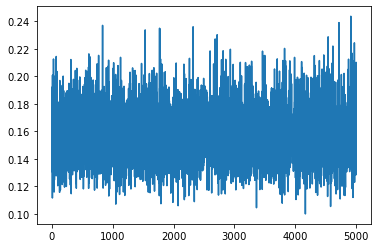

 84%|██████████████████████████████████████████████████████████████▉            | 83997/100000 [19:41<03:49, 69.72it/s]

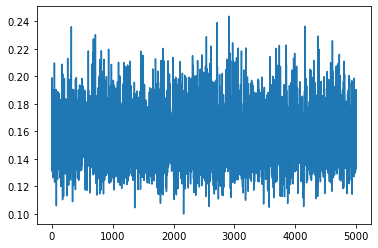

 86%|████████████████████████████████████████████████████████████████▍          | 85996/100000 [20:09<03:07, 74.69it/s]

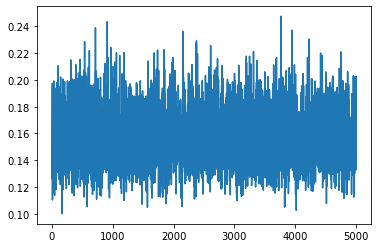

 88%|██████████████████████████████████████████████████████████████████         | 88000/100000 [20:37<02:39, 75.30it/s]

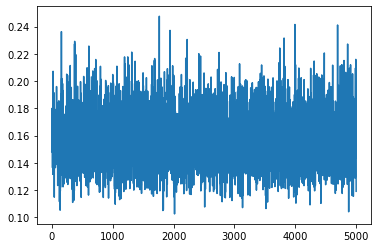

 90%|███████████████████████████████████████████████████████████████████▍       | 89997/100000 [21:06<02:47, 59.70it/s]

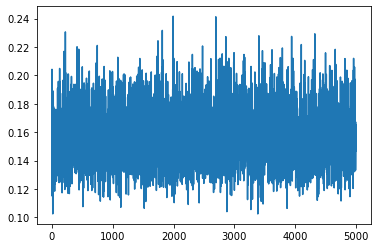

 92%|████████████████████████████████████████████████████████████████████▉      | 91994/100000 [21:36<01:59, 66.91it/s]

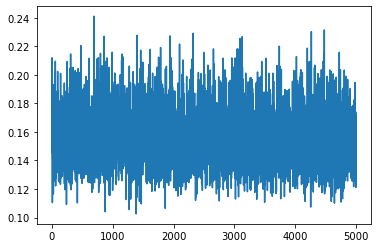

 94%|██████████████████████████████████████████████████████████████████████▍    | 93993/100000 [22:06<01:25, 70.62it/s]

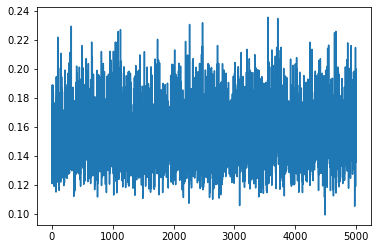

 96%|████████████████████████████████████████████████████████████████████████   | 96000/100000 [22:34<00:53, 74.41it/s]

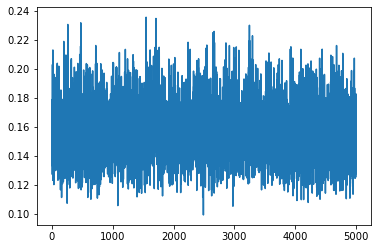

 98%|█████████████████████████████████████████████████████████████████████████▌ | 98000/100000 [23:02<00:28, 69.52it/s]

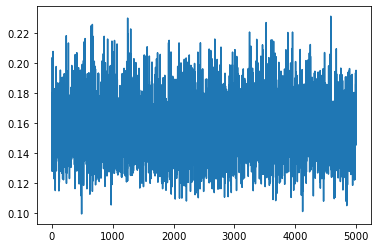

100%|██████████████████████████████████████████████████████████████████████████▉| 99992/100000 [23:29<00:00, 73.33it/s]

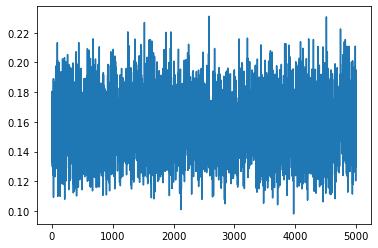

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

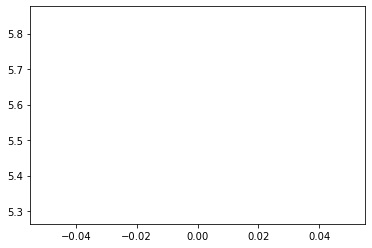

  2%|█▌                                                                          | 1994/100000 [00:27<21:55, 74.49it/s]

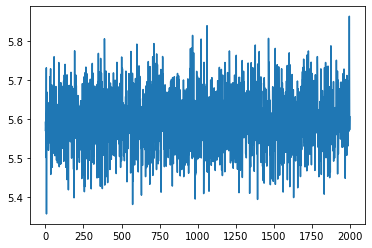

  4%|███                                                                         | 4000/100000 [00:54<23:50, 67.12it/s]

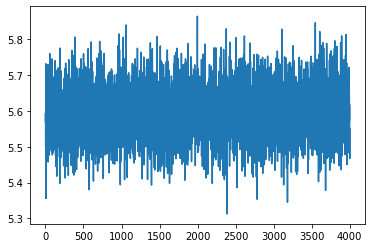

  6%|████▌                                                                       | 5993/100000 [01:22<22:11, 70.59it/s]

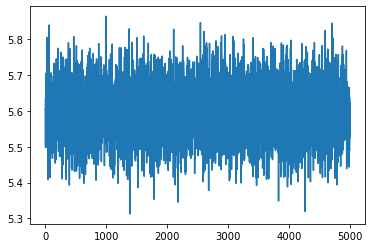

  8%|██████                                                                      | 7994/100000 [01:49<20:32, 74.67it/s]

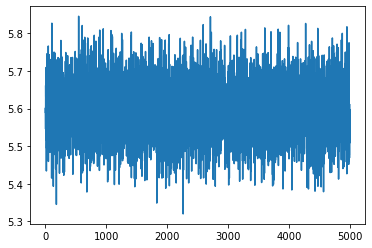

 10%|███████▌                                                                   | 10000/100000 [02:17<20:36, 72.76it/s]

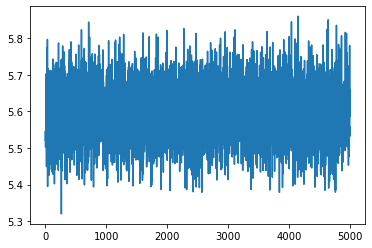

 12%|████████▉                                                                  | 11996/100000 [02:44<19:47, 74.12it/s]

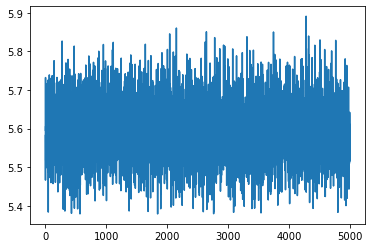

 14%|██████████▍                                                                | 13995/100000 [03:11<18:46, 76.32it/s]

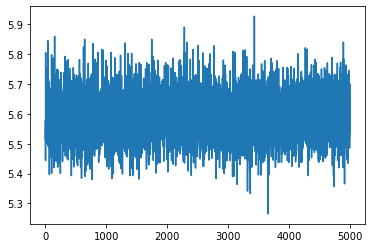

 16%|███████████▉                                                               | 15993/100000 [03:38<19:39, 71.21it/s]

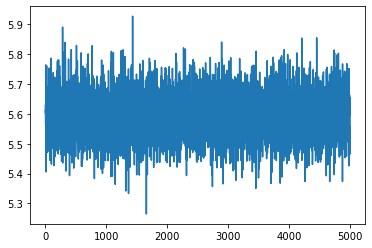

 18%|█████████████▍                                                             | 17993/100000 [04:06<18:33, 73.62it/s]

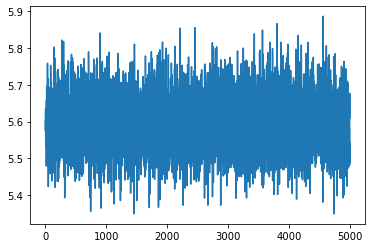

 20%|███████████████                                                            | 20000/100000 [04:33<19:31, 68.29it/s]

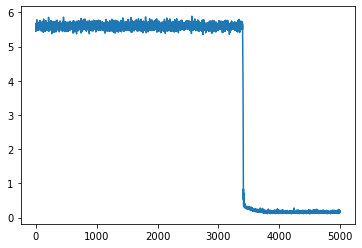

 22%|████████████████▍                                                          | 21996/100000 [05:01<18:03, 71.98it/s]

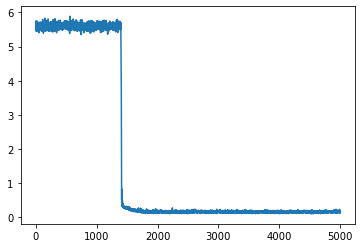

 24%|█████████████████▉                                                         | 23995/100000 [05:28<17:30, 72.33it/s]

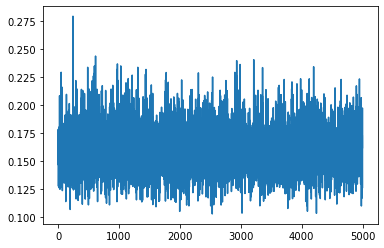

 26%|███████████████████▍                                                       | 25995/100000 [05:55<16:07, 76.51it/s]

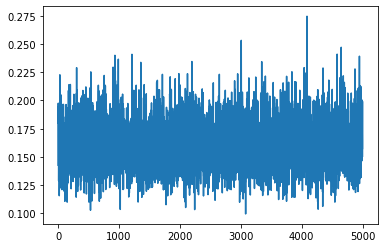

 28%|████████████████████▉                                                      | 27996/100000 [06:22<16:46, 71.56it/s]

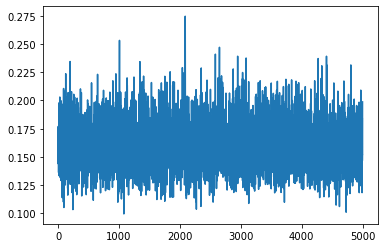

 30%|██████████████████████▌                                                    | 30000/100000 [06:50<15:43, 74.16it/s]

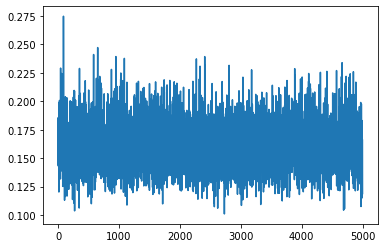

 32%|███████████████████████▉                                                   | 31996/100000 [07:17<15:12, 74.51it/s]

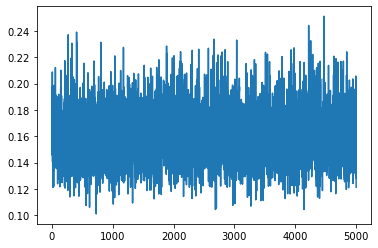

 34%|█████████████████████████▍                                                 | 33998/100000 [07:44<14:59, 73.40it/s]

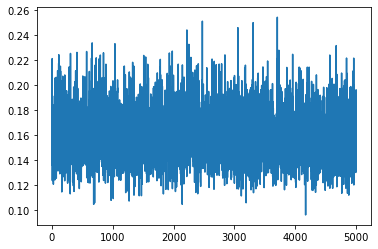

 36%|██████████████████████████▉                                                | 35993/100000 [08:12<14:31, 73.49it/s]

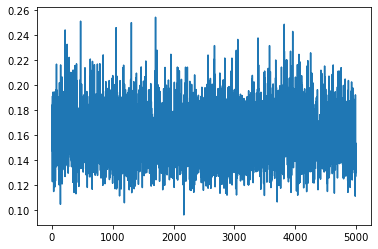

 38%|████████████████████████████▍                                              | 37998/100000 [08:39<13:53, 74.36it/s]

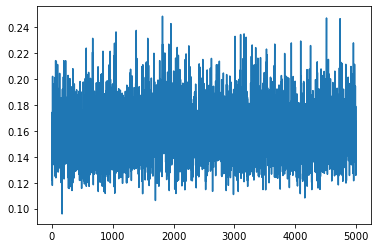

 40%|█████████████████████████████▉                                             | 39997/100000 [09:07<13:22, 74.79it/s]

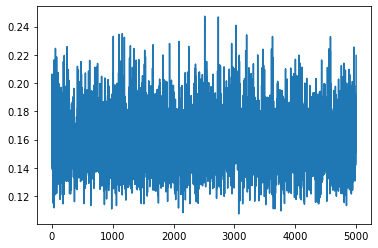

 42%|███████████████████████████████▍                                           | 41996/100000 [09:34<12:49, 75.42it/s]

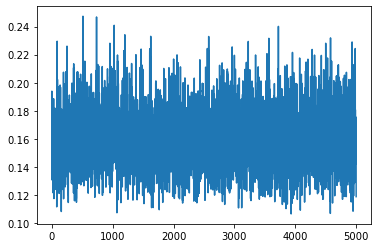

 44%|████████████████████████████████▉                                          | 43998/100000 [10:02<12:41, 73.54it/s]

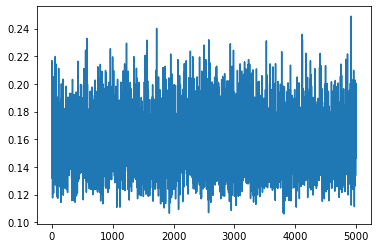

 46%|██████████████████████████████████▍                                        | 45993/100000 [10:29<12:05, 74.44it/s]

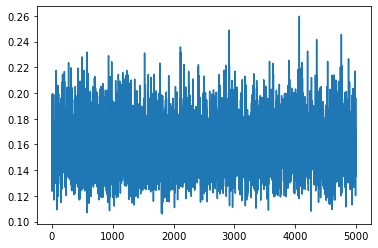

 48%|███████████████████████████████████▉                                       | 47993/100000 [10:57<11:42, 74.01it/s]

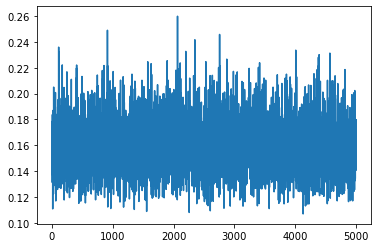

 50%|█████████████████████████████████████▍                                     | 49998/100000 [11:24<12:26, 67.01it/s]

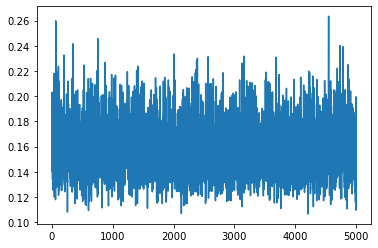

 51%|██████████████████████████████████████▏                                    | 50927/100000 [11:37<11:12, 72.99it/s]


KeyboardInterrupt: 

In [82]:
"""
train MAP model
"""
nb_epochs, batch_size = 100000, 256

fit_loss_train = np.zeros(nb_epochs)
best_net, best_loss = None, float('inf')
num_nets, nets, losses = 2, [], {}

for n in range(num_nets):

    net = Net(n_feature=input_dim, n_hidden=200, n_output=output_dim, learn_rate=1e-2, weight_decay=1e-1).cuda()
    
    losses[n] = []
    for i in tqdm(range(nb_epochs)):
        """ pick subgraphs """
        sub_idx = np.random.choice(np.arange(0, len(x_train)), size = batch_size, replace=False)
        x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]

        # train on subset
        loss = net.fit(x_train_sub, y_train_sub)
        losses[n].append(loss.cpu().data.numpy())
        
        if (i % 2000 == 0) | (i == nb_epochs-1):
            plt.plot(losses[n][-5000:])
            plt.show()
#             print('Network %2d, Epoch %4d, Train loss = %6.3f' % (len(nets)+1, i, np.mean(losses[n])))

    nets.append(copy.deepcopy(net))

100%|████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:01<00:00, 1095.51it/s]


0.1593446284532547

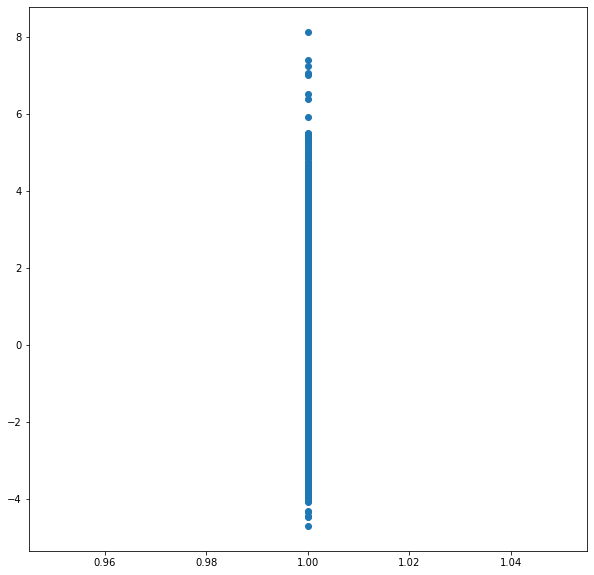

In [83]:
"""
test on training dataset
"""

# net = nets[0]

values, noises, labels = [], [], []
# get batch by batch
for i in tqdm(range(0, x_train.shape[0], batch_size)):
    xinput = x_train[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()
    
    yinput = y_train[i:i+batch_size]
    
    preds = net(xinput)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )
    noises.extend(
        list(preds[:, 1].exp().cpu().data.numpy())
    )
    labels.extend(
        yinput
    )
       
values = np.array(values)
noises = np.array(noises)


"""
check if there's correlation between uncertainty and regression error
"""
error = values - y_train[:, 0]
plt.figure(figsize=(10, 10))
plt.scatter(noises, error)

"""
check error
"""
input_dict = {"y_true": torch.tensor(y_train[:, 0]), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

In [33]:
"""
save model
"""
for i, net in enumerate(nets):
    checkpoint = dict([(i, net.state_dict()) for i, net in enumerate(nets)])
    torch.save(checkpoint, os.path.join(args.checkpoint_dir, 'bnn-map-checkpoint.pt'))

## BBP

In [12]:
def neg_log_like(output, target, sigma):
    """
    Negative gaussian log likelihood (scaled, per example)
    """
    
    exponent = -0.5*torch.sum(
        (target - output)**2/sigma**2
        , 1)

    log_coeff = -torch.sum(torch.log(sigma)) - len(sigma) * torch.log(torch.sqrt(torch.tensor(2*np.pi)))
    
    scale = 1 / len(exponent)
    
    return - scale * (log_coeff + exponent).sum()

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

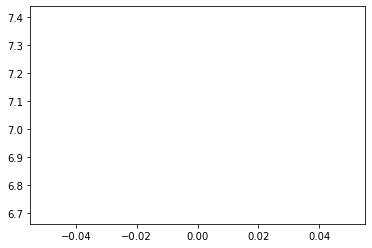

 10%|███████▊                                                                       | 199/2000 [00:12<01:51, 16.20it/s]

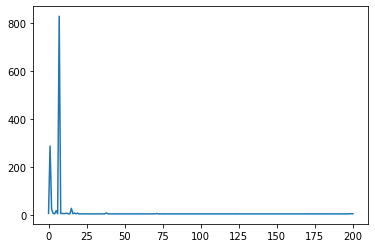

 20%|███████████████▊                                                               | 399/2000 [00:24<01:37, 16.47it/s]

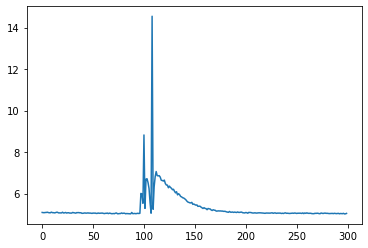

 30%|███████████████████████▋                                                       | 599/2000 [00:36<01:27, 15.93it/s]

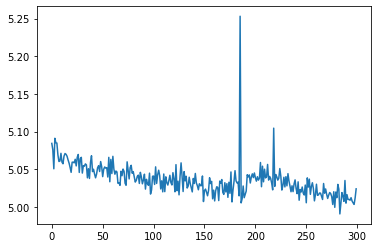

 40%|███████████████████████████████▌                                               | 799/2000 [00:52<01:13, 16.45it/s]

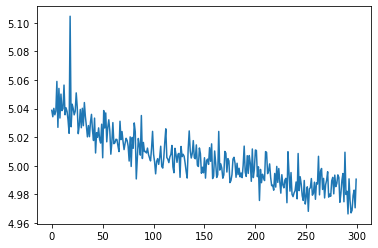

 50%|███████████████████████████████████████▍                                       | 999/2000 [01:04<00:57, 17.28it/s]

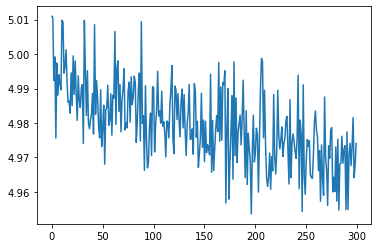

 60%|██████████████████████████████████████████████▊                               | 1199/2000 [01:15<00:50, 15.96it/s]

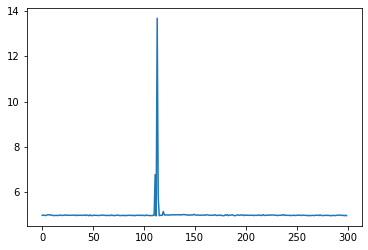

 70%|██████████████████████████████████████████████████████▌                       | 1400/2000 [01:26<00:31, 18.91it/s]

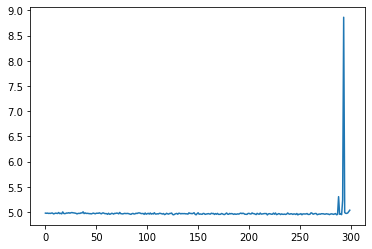

 80%|██████████████████████████████████████████████████████████████▎               | 1599/2000 [01:36<00:21, 18.35it/s]

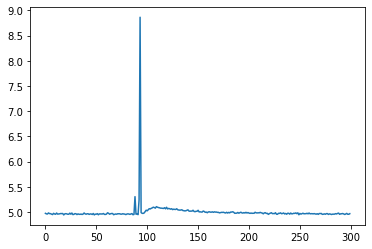

 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [01:47<00:10, 18.34it/s]

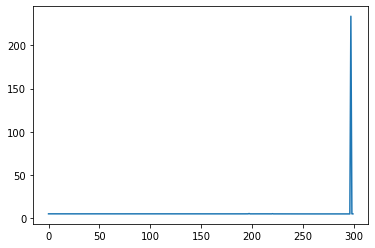

100%|█████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [01:58<00:00, 18.68it/s]

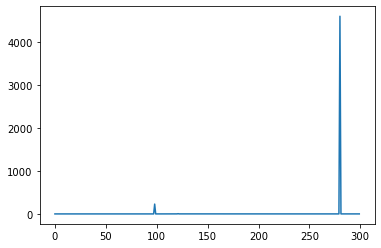

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:58<00:00, 16.83it/s]


In [15]:
"""
train BBP model
"""
# define model
model = ModelBBP(input_dim=input_dim, output_dim=output_dim)
model.cuda()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
# train
log_noise = nn.Parameter(torch.ones(1))
log_noise = torch.exp(log_noise).cuda()

# iteration loop
nb_epochs = 2000 
batch_size = 256
losses = []
for i in tqdm(range(nb_epochs)):
    """ pick subgraphs """
    sub_idx = np.random.choice(np.arange(0, len(x_train)), size = batch_size, replace=True)
    x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]
    train_data_size = x_train_sub.shape[0]

    # train on subset
    optimizer.zero_grad()

    # move to cuda
    x_train_sub = torch.Tensor(x_train_sub).cuda()
    y_train_sub = torch.Tensor(y_train_sub).cuda()

    # get out and loss
    out, kld = model.forward(x_train_sub, sample=False)

    # total loss = prediction error + kld
    kl_loss = kld / train_data_size
    loss = neg_log_like(out, y_train_sub, log_noise) + 0.01*kl_loss 

    # train
    loss.backward(retain_graph=True)
    optimizer.step()

    # append loss
    lossVal = loss.cpu().data.numpy().tolist()
    losses.append(lossVal)

    if lossVal < bestLoss:
        bestLoss = lossVal
        bestModel = copy.deepcopy(model)

    if (i % 200 == 0) | (i == nb_epochs-1):
        plt.plot(losses[-300:])
        plt.show()


100%|███████████████████████████████████████████████████████████████████████████| 11896/11896 [01:10<00:00, 168.15it/s]


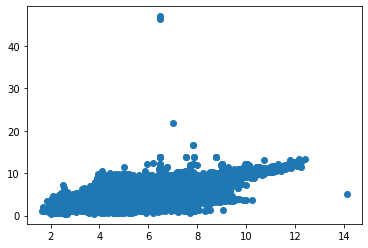

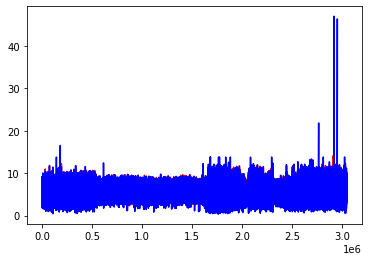

0.1301458775997162

In [47]:
"""
visualise regression output
"""
net = bestModel

# get batch by batch
values = []
labels = []
for i in tqdm(range(0, x_train.shape[0], batch_size)):
    xinput = x_train[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()

    yinput = y_train[i:i+batch_size]

    preds, _ = net(xinput, sample=False)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )

    labels.extend(
        list(yinput.flatten())
    )


# visualise
plt.scatter(values, labels)
plt.show()

plt.plot(values, "r")
plt.plot(labels, "b")
plt.show()

"""
check error
"""
input_dict = {"y_true": torch.tensor(labels), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

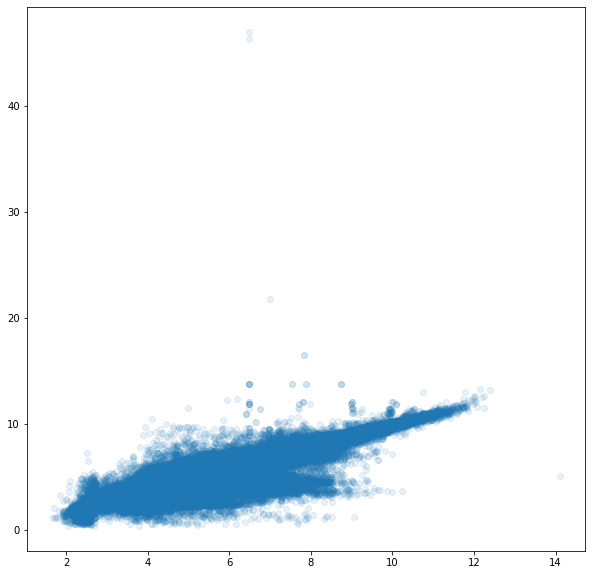

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(values, labels, alpha=0.1)
plt.show()

In [41]:
"""
save model
"""
torch.save(bestModel, os.path.join(args.checkpoint_dir, 'bnn-bbp-model-checkpoint.pt'))

PicklingError: Can't pickle <class '__main__.ModelBBP'>: it's not the same object as __main__.ModelBBP

evaluate on test dataset

In [42]:
"""
Load GNN Model
"""

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


modelName = "gin-virtual"
gnn_type = "gin"
virtual_node = True
   
# load checkpoint data
filename = os.path.join(args.checkpoint_dir, "models", modelName, "checkpoint", 'checkpoint.pt')
checkpoint = torch.load(filename)

# load model
gnnmodel = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
gnnmodel.load_state_dict(checkpoint["model_state_dict"])
# model.eval()    


<All keys matched successfully>

In [43]:
"""
Load Valid Datasets and extract graph embeddings
"""

def getGraphEmbedding(model, batch):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

# get loader dataset
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

"""
Get intermediate graph embeddings and visualise
"""
graphEmbeddingsList = []
y_true = []
y_pred = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(gnnmodel, batch)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    y_pred.extend(pred_np)

    # collate graph embedding
    h_graph_np = h_graph.detach().cpu().numpy()
    graphEmbeddingsList.append(h_graph_np)

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    
    
"""
Combine Graph Embeddings
"""
Ndata = len(y_true)
dim = 600
graphEmbeddings = np.zeros((Ndata, dim))

Nval = 1487

# load separately as np.concatenate is too slow
for step in tqdm(range(Nval)):

    h_graph_np = graphEmbeddingsList[step]
    
    minVal = step*256
    maxVal = min((step+1)*256, Ndata)
    graphEmbeddings[minVal:maxVal, :] = h_graph_np
    
graphEmbeddings.shape

100%|█████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:02<00:00, 538.98it/s]


(380670, 600)

100%|█████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:02<00:00, 553.48it/s]


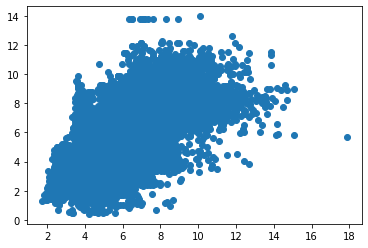

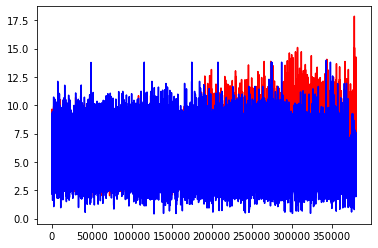

0.4898448884487152

In [49]:
"""
Evaluate
"""

# get x test
x_test = graphEmbeddings
y_test = y_true

# get evaluator
batch_size = 256
evaluator = PCQM4MEvaluator()

# evaluate per batch
values, noises, labels = [], [], []
# get batch by batch
for i in tqdm(range(0, x_test.shape[0], batch_size)):
    xinput = x_test[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()
    
    yinput = y_test[i:i+batch_size]
    
    preds, _ = bestModel(xinput, sample=False)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )
    labels.extend(
        yinput
    )
       
values = np.array(values)

# visualise
plt.scatter(values, labels)
plt.show()

plt.plot(values, "r")
plt.plot(labels, "b")
plt.show()

"""
check error
"""
input_dict = {"y_true": torch.tensor(labels), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

### MC Dropout

In [66]:
"""
DEBUG: Define MC Dropout Model
"""
class MC_Dropout_Model(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob, learn_rate, batch_size, weight_decay):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        self.activation = nn.ReLU(inplace = True)

        # learning hyperparameters
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        # get optimizer
#         self.optimizer = torch.optim.SGD(self.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

        self.loss_func = log_gaussian_loss

    def fit(self, x, y):
        # convert to cuda tensors
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        # propagate forward
        output = self.forward(x)
        ## TODO: IMPORTANT TO ADD SMALL ERROR, otherwise output goes to 0 and loss becomes nan
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
#         loss = self.loss_func(output[:, :1] + 1e-12, y, (output[:, 1:].exp()+1e-12), 1)
        
        L1loss = torch.nn.L1Loss()(output[:, :1], y)
#         loss = L1loss
        
        # train
        loss.backward()
        self.optimizer.step()

#         return loss
        return L1loss

    
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        
        # first layer
        x = self.layer1(x)
        x = self.activation(x)
        # ADDITIONAL dropout acts as ensembling
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        # second layer
        x = self.layer2(x)
        x = self.activation(x)
        
        return x

  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

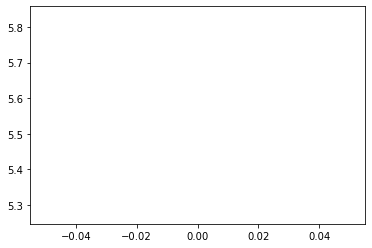

  4%|██▉                                                                         | 1972/50000 [00:07<02:49, 283.61it/s]

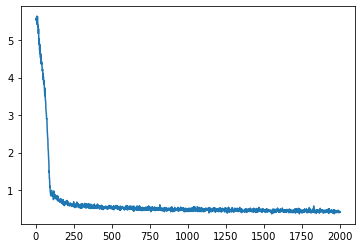

  8%|██████                                                                      | 3989/50000 [00:14<03:01, 254.20it/s]

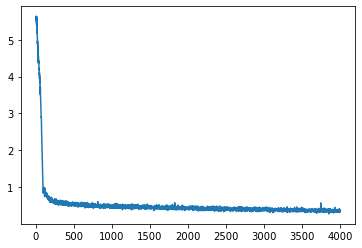

 12%|█████████                                                                   | 5986/50000 [00:23<03:05, 237.08it/s]

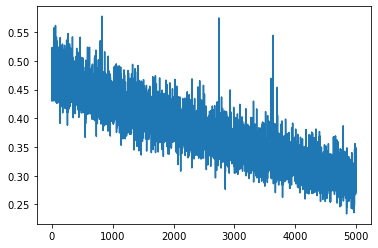

 16%|████████████▏                                                               | 7990/50000 [00:32<03:08, 222.39it/s]

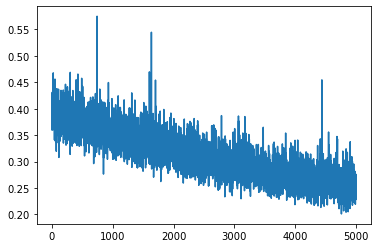

 20%|███████████████▏                                                            | 9996/50000 [00:41<03:06, 214.04it/s]

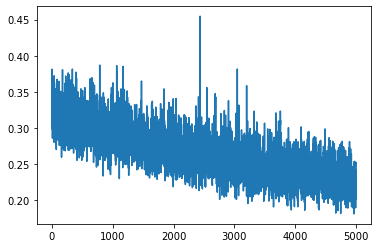

 24%|█████████████████▉                                                         | 11992/50000 [00:50<02:43, 232.33it/s]

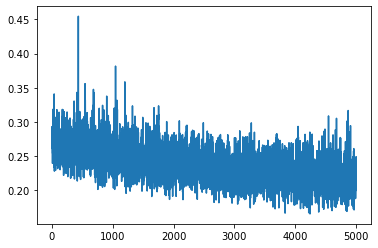

 28%|████████████████████▉                                                      | 13989/50000 [00:59<02:29, 241.62it/s]

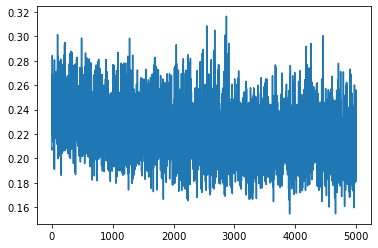

 32%|███████████████████████▉                                                   | 15977/50000 [01:08<02:21, 240.56it/s]

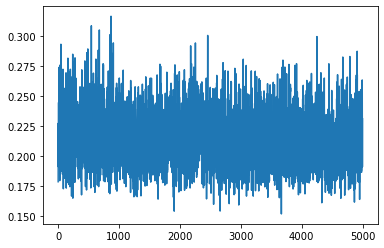

 36%|██████████████████████████▉                                                | 17980/50000 [01:17<02:28, 215.81it/s]

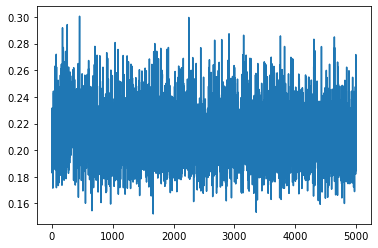

 40%|█████████████████████████████▉                                             | 19996/50000 [01:27<02:08, 233.70it/s]

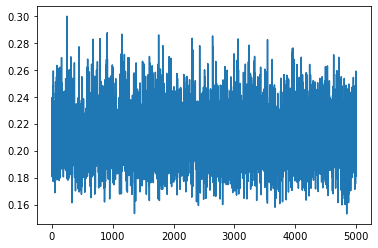

 44%|████████████████████████████████▉                                          | 21997/50000 [01:36<01:58, 235.83it/s]

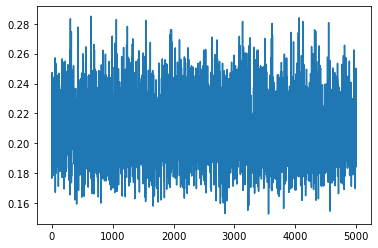

 48%|███████████████████████████████████▉                                       | 23981/50000 [01:45<01:54, 226.61it/s]

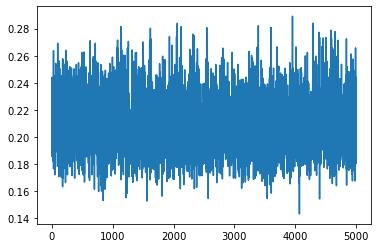

 52%|██████████████████████████████████████▉                                    | 25986/50000 [01:54<01:55, 207.38it/s]

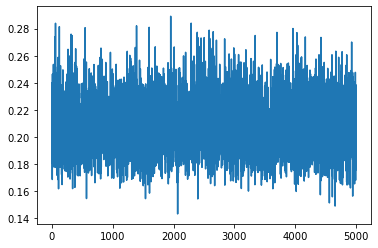

 54%|████████████████████████████████████████▏                                  | 26805/50000 [01:58<01:42, 225.98it/s]


KeyboardInterrupt: 

In [67]:
"""
train MC model
"""
nb_epochs, batch_size = 50000, 256

fit_loss_train = np.zeros(nb_epochs)
best_net, best_loss = None, float('inf')
num_nets, nets, losses = 2, [], {}

for n in range(num_nets):

    net = MC_Dropout_Model(input_dim=input_dim, output_dim=output_dim, 
                           num_units=200, drop_prob=0.5, learn_rate=1e-4, 
                           batch_size=batch_size, weight_decay=1e-2)
    net.cuda()
    
    losses[n] = []
    for i in tqdm(range(nb_epochs)):
        """ pick subgraphs """
        sub_idx = np.random.choice(np.arange(0, len(x_train)), size = batch_size, replace=True)
        x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]

        # train on subset
        loss = net.fit(x_train_sub, y_train_sub)
        losses[n].append(loss.cpu().data.numpy())
        
        if (i % 2000 == 0) | (i == nb_epochs-1):
            plt.plot(losses[n][-5000:])
            plt.show()
#             print('Network %2d, Epoch %4d, Train loss = %6.3f' % (len(nets)+1, i, np.mean(losses[n])))

    nets.append(copy.deepcopy(net))

100%|████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:01<00:00, 1081.63it/s]


0.2054835855960846

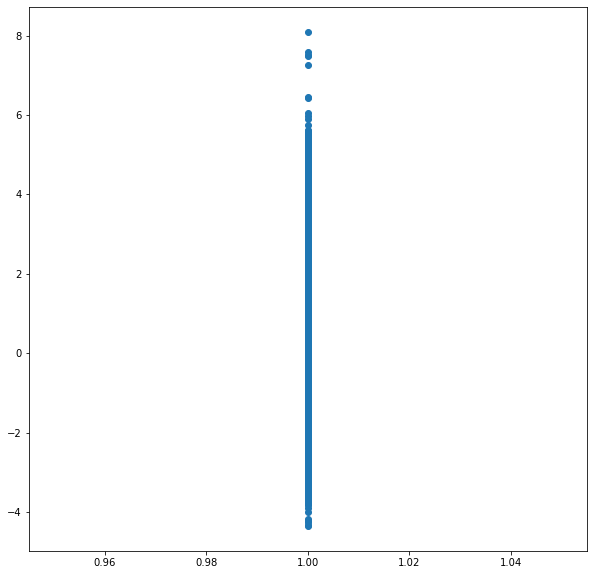

In [68]:
"""
test on training dataset
"""

# net = nets[0]

values, noises, labels = [], [], []
# get batch by batch
for i in tqdm(range(0, x_train.shape[0], batch_size)):
    xinput = x_train[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()
    
    yinput = y_train[i:i+batch_size]
    
    preds = net(xinput)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )
    noises.extend(
        list(preds[:, 1].exp().cpu().data.numpy())
    )
    labels.extend(
        yinput
    )
       
values = np.array(values)
noises = np.array(noises)


"""
check if there's correlation between uncertainty and regression error
"""
error = values - y_train[:, 0]
plt.figure(figsize=(10, 10))
plt.scatter(noises, error)

"""
check error
"""
input_dict = {"y_true": torch.tensor(y_train[:, 0]), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

In [32]:
"""
save model
"""
for i, net in enumerate(nets):
    checkpoint = dict([(i, net.state_dict()) for i, net in enumerate(nets)])
    torch.save(checkpoint, os.path.join(args.checkpoint_dir, 'bnn-mc-dropout-checkpoint.pt'))

## Stochastic Langevin Gradient Descent

## load valid datasets

In [29]:
net = torch.load(os.path.join(args.checkpoint_dir, 'bnn-bbp-checkpoint.pt'))
nets = [net]
nets

[ModelBBP(
   (l1): BayesLinear()
   (l2a): BayesLinear()
   (l2b): BayesLinear()
   (l3): BayesLinear()
   (activation): ReLU(inplace=True)
 )]

### 3. load valid datasets, GNN model and BNN model

In [6]:
"""
LOAD BNN Model
"""
# bnn_checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'bnn-map-checkpoint.pt'))
bnn_checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'bnn-mc-dropout-checkpoint.pt'))

Nmodels = max(bnn_checkpoint.keys())

bnn_checkpoint, Nmodels

({0: OrderedDict([('layer1.weight',
                tensor([[-2.9691e-02, -3.1423e-02,  1.5337e-02,  ..., -4.3151e-03,
                          9.5139e-03,  2.5546e-02],
                        [ 7.8887e-05,  2.6364e-03,  2.7709e-02,  ..., -1.6037e-02,
                         -1.6153e-02,  2.9555e-02],
                        [ 3.3373e-02,  1.8486e-02, -8.5442e-03,  ..., -2.0421e-02,
                          3.2013e-02, -3.8085e-02],
                        ...,
                        [ 7.7311e-03,  1.8941e-02, -1.0208e-02,  ...,  3.8028e-03,
                          3.7862e-02, -9.5486e-03],
                        [-2.5365e-04,  3.3754e-02, -1.5665e-02,  ...,  1.7056e-02,
                         -2.0798e-02, -2.3342e-02],
                        [ 1.8556e-02, -2.9078e-02, -3.0235e-02,  ..., -1.0160e-02,
                         -2.8669e-02, -9.6635e-04]], device='cuda:0')),
               ('layer1.bias',
                tensor([-3.0609e-01, -3.0540e-01, -1.3871e-02, -1.1751e-02

In [7]:
"""
CODE to load model state dict
"""
nets = []
for i in range(Nmodels+1):
    net = Net(n_feature=input_dim, n_hidden=200, n_output=output_dim, learn_rate=1e-2, weight_decay=1e-1).cuda()
    net.load_state_dict(bnn_checkpoint[i])
    
    nets.append(net)

In [33]:
"""
Load GNN Model
"""

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


modelName = "gin-virtual"
gnn_type = "gin"
virtual_node = True
   
# load checkpoint data
filename = os.path.join(args.checkpoint_dir, "models", modelName, "checkpoint", 'checkpoint.pt')
checkpoint = torch.load(filename)

# load model
model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()    


<All keys matched successfully>

In [31]:
"""
Load Valid Datasets and extract graph embeddings
"""

def getGraphEmbedding(model, batch):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

# get loader dataset
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

"""
Get intermediate graph embeddings and visualise
"""
graphEmbeddingsList = []
y_true = []
y_pred = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(model, batch)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    y_pred.extend(pred_np)

    # collate graph embedding
    h_graph_np = h_graph.detach().cpu().numpy()
    graphEmbeddingsList.append(h_graph_np)

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    
    
"""
Combine Graph Embeddings
"""
Ndata = len(y_true)
dim = 600
graphEmbeddings = np.zeros((Ndata, dim))

Nval = 1487

# load separately as np.concatenate is too slow
for step in tqdm(range(Nval)):

    h_graph_np = graphEmbeddingsList[step]
    
    minVal = step*256
    maxVal = min((step+1)*256, Ndata)
    graphEmbeddings[minVal:maxVal, :] = h_graph_np

100%|█████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:02<00:00, 726.43it/s]


In [32]:
"""
Evaluate
"""

# get x test
x_test = graphEmbeddings
y_test = y_true

# get evaluator
batch_size = 256
evaluator = PCQM4MEvaluator()

# test
net = nets[0]

values, noises, labels = [], [], []
# get batch by batch
for i in tqdm(range(0, x_test.shape[0], batch_size)):
    xinput = x_test[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()
    
    yinput = y_test[i:i+batch_size]
    
    preds, _ = net(xinput)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )
#     noises.extend(
#         list(preds[:, 1].exp().cpu().data.numpy())
#     )
    labels.extend(
        yinput
    )
       
values = np.array(values)
# noises = np.array(noises)

input_dict = {"y_true": torch.tensor(y_test), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

100%|█████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:03<00:00, 390.39it/s]


1.4353296756744385

In [ ]:
"""
Evaluate
"""

# get x test
x_test = graphEmbeddings
y_test = y_true

# get evaluator
batch_size = 256
evaluator = PCQM4MEvaluator()

# test
net = nets[0]

values, noises, labels = [], [], []
# get batch by batch
for i in tqdm(range(0, x_test.shape[0], batch_size)):
    xinput = x_test[i:i+batch_size]
    xinput = torch.from_numpy(xinput).type(torch.FloatTensor).cuda()
    
    yinput = y_test[i:i+batch_size]
    
    preds = net(xinput)
    values.extend(
        list(preds[:, 0].cpu().data.numpy())
    )
    noises.extend(
        list(preds[:, 1].exp().cpu().data.numpy())
    )
    labels.extend(
        yinput
    )
       
values = np.array(values)
noises = np.array(noises)

input_dict = {"y_true": torch.tensor(y_test), "y_pred": torch.tensor(values)}
evaluator.eval(input_dict)["mae"]

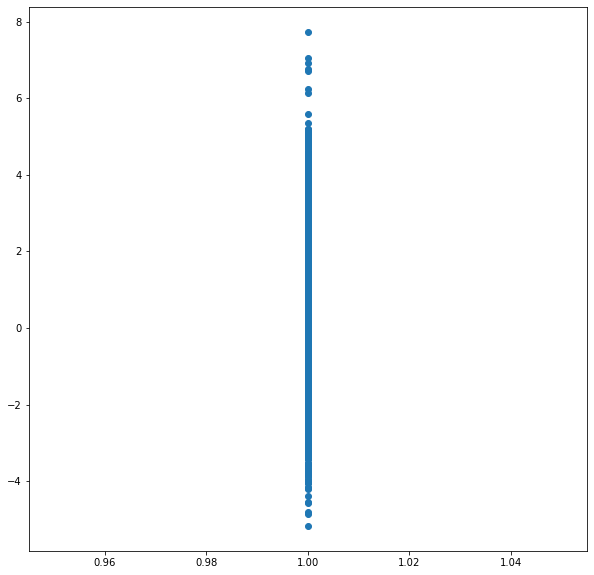

In [14]:
"""
check if there's correlation between uncertainty and regression error
"""

error = values - y_test
plt.figure(figsize=(10, 10))
plt.scatter(noises, error)

### activate dropout during inference

not sure what to make out of this since the error rate is higher than baseline.

maybe can say if uncertainty is high, then we can't really say anything about the accuracy

In [6]:
model

GNN(
  (gnn_node): GNN_node_Virtualnode(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 600)
        (1): Embedding(4, 600)
        (2): Embedding(12, 600)
        (3): Embedding(12, 600)
        (4): Embedding(10, 600)
        (5): Embedding(6, 600)
        (6): Embedding(6, 600)
        (7): Embedding(2, 600)
        (8): Embedding(2, 600)
      )
    )
    (virtualnode_embedding): Embedding(1, 600)
    (convs): ModuleList(
      (0): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=600, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=600, out_features=600, bias=True)
        )
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): Embedding(5, 600)
            (1): Embedding(6, 600)
            (2): Embedding(2, 600)
          )
     

In [7]:
model.drop_ratio, model.gnn_node.drop_ratio

(0, 0)

In [8]:
"""
Load Valid Datasets and extract graph embeddings
"""

def getGraphEmbedding(model, batch):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

# get loader dataset
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)


In [23]:
"""
get full prediction
"""
model.eval()
list(model.children())[0].training = False
model.drop_ratio = 0
model.gnn_node.drop_ratio = 0

y_true = []
y_pred = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
#     h_graph, pred = getGraphEmbedding(model, batch)
    with torch.no_grad():
        pred = model(batch)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()[:, 0]
    y_pred.extend(pred_np)

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    
#     break
    
# calculate errors
errors = abs(np.array(y_pred) - np.array(y_true))
errors

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:31<00:00, 16.28it/s]


array([0.03820229, 0.02901268, 0.19020224, ..., 0.26905584, 0.00743961,
       0.12001467], dtype=float32)

In [24]:
# error from pure point detection
np.mean(errors)

0.15115169

In [25]:
# set model to train mode
# set gnn training to true, but not everything (otherwise starts changing the weights?)
list(model.children())[0].training = True

model.drop_ratio = 0.1 # 0.05
model.gnn_node.drop_ratio = 0.1 #0.05

model.training, model.drop_ratio

(False, 0.1)

In [26]:
"""
Get dropout prediction
"""
num_samples = 10

y_preds = []
for _ in range(num_samples):
    y_pred = []
    for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

        # put batch to cuda
        batch = batch.to(device)

#         # get embedding
#         h_graph, pred = getGraphEmbedding(model, batch)

        with torch.no_grad():
            pred = model(batch)
            # clamp pred like inference
            pred = torch.clamp(pred, min=0, max=50)

        # collate prediction
        pred_np = pred.detach().cpu().numpy()[:, 0]
        y_pred.extend(pred_np)

#         break
        
    y_preds.append(y_pred)

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:34<00:00, 15.74it/s]


0.17184329

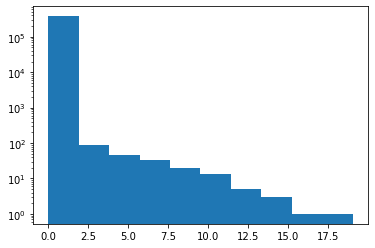

In [27]:
# errors from dropout
errors = abs(np.median(y_preds, axis=0) - np.array(y_true))

plt.hist(np.std(y_preds, axis=0), log=True)

np.mean(errors)

In [28]:
# mean prediction
y_preds = np.array(y_preds)

# calculate noises based on dropout
noises = y_preds.std(axis=0)

noises.shape

(380670,)

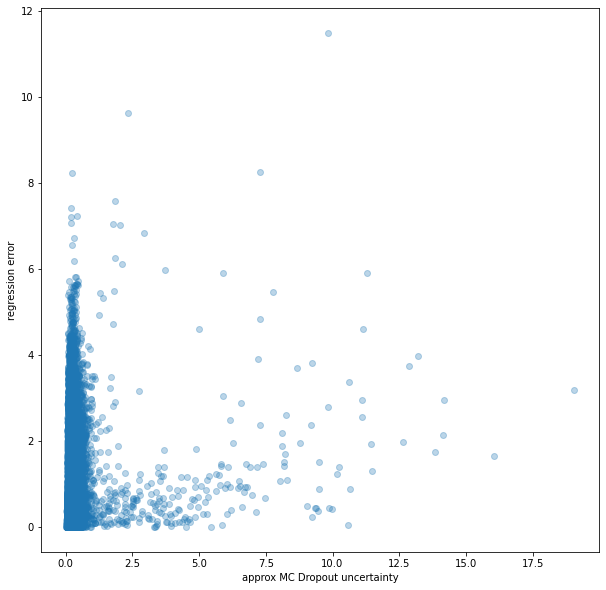

In [44]:
# plot noise vs error
plt.figure(figsize=(10, 10))
plt.xlabel("approx MC Dropout uncertainty")
plt.ylabel("regression error")
plt.scatter(noises, errors, alpha=0.3)
plt.show()

In [30]:
noiseDF = pd.DataFrame(zip(noises, errors), columns=["noise", "error"])
noiseDF[noiseDF.noise < 0.02]

,noise,error
161110,0.019388,0.032102


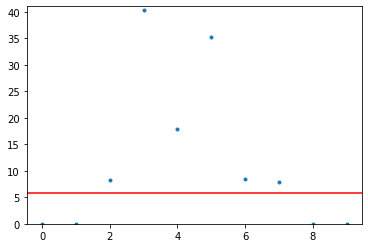

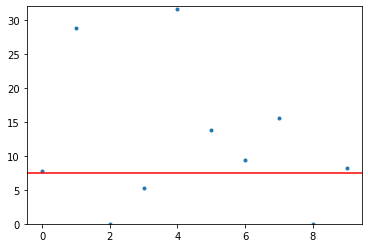

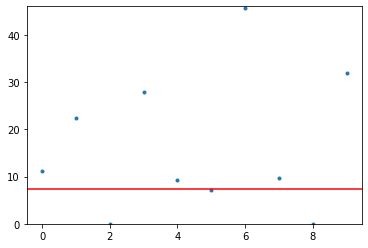

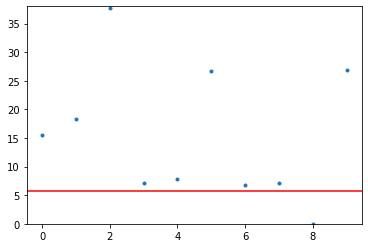

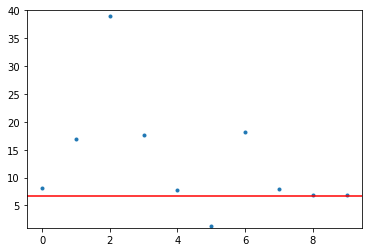

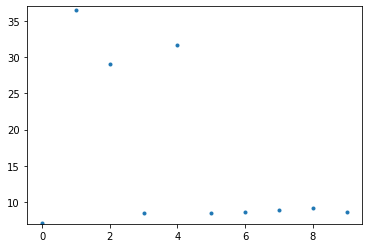

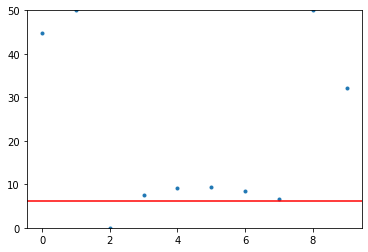

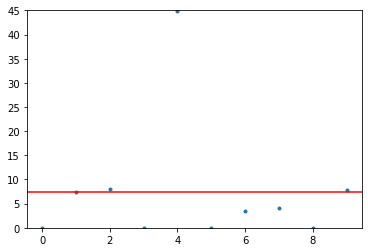

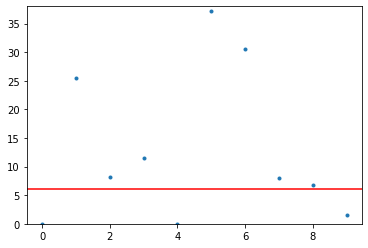

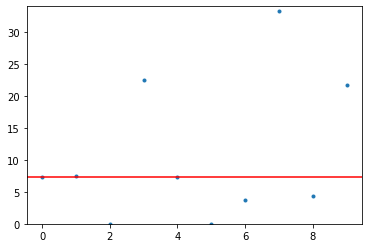

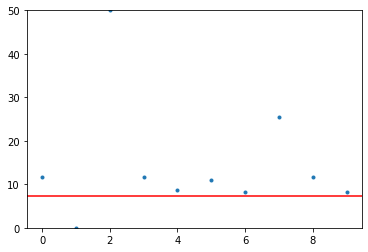

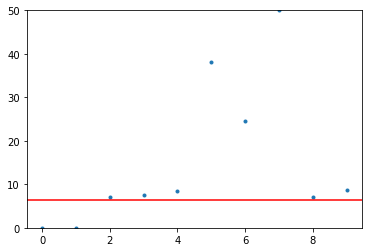

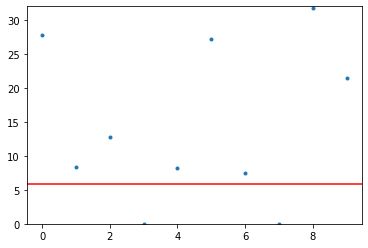

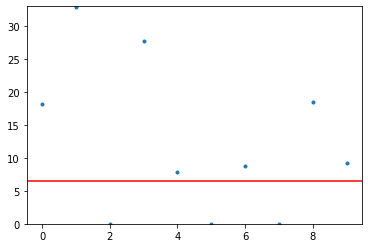

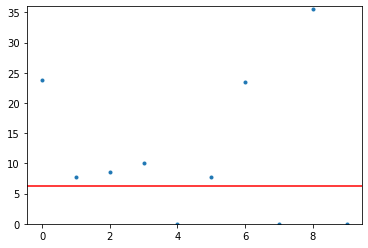

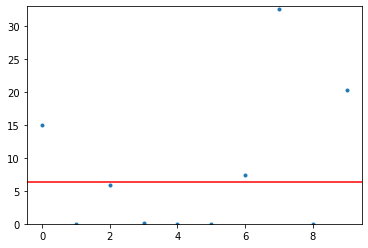

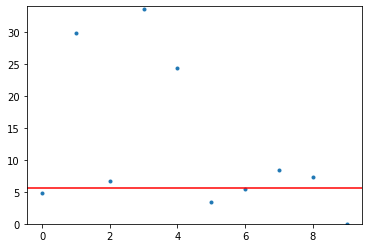

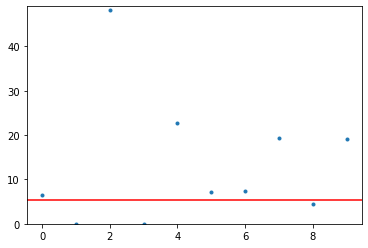

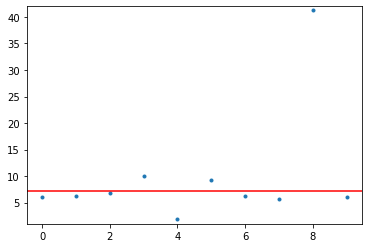

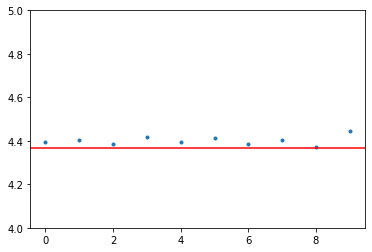

In [31]:
for i in noiseDF[noiseDF.noise > 10].index:
    plt.plot(y_preds[:, i], ".")
    plt.axhline(y_true[i], color="r")

    bot = np.floor(y_preds[:, i].min())
    up = np.ceil(y_preds[:, i].max())
    plt.ylim(bot, up)
    plt.show()
    
for i in noiseDF[noiseDF.noise < 0.02].index:
    plt.plot(y_preds[:, i], ".")
    plt.axhline(y_true[i], color="r")
    
    bot = np.floor(y_preds[:, i].min())
    up = np.ceil(y_preds[:, i].max())
    plt.ylim(bot, up)
    plt.show()

In [36]:
# plot patterns

import networkx as nx
import matplotlib.pyplot as plt

def plotGraph(data, y_pred, y_true, std, ax, printnodelabel=False, printedgelabel=False, set_title=True):

    edges = data.edge_index.T.tolist()
    edges = np.array(edges)
    edges = [(x[0][0], x[0][1], {"feat": str(x[1])}) for x in list(zip(edges.tolist(), data.edge_attr.tolist()))]
    nodes = [(x[0], {"feat": str(x[1])}) for x in enumerate(data.x.tolist())]

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nodelabels = nx.get_node_attributes(G, 'feat') 
    edgelabels = nx.get_edge_attributes(G, "feat")

    pos = nx.spring_layout(G)
    if set_title:
        ax.set_title("pred={:.2f}, true={:.2f}, std={:.2f}".format(y_pred, y_true, std))
    if printnodelabel:
        nx.draw(G, pos, labels=nodelabels, ax=ax, node_size=40)
    else:
        nx.draw(G, pos, ax=ax, node_size=40)
        
    if printedgelabel:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edgelabels)


In [20]:
## collate data as a list

valid_data_list = []
y_true = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # collate data
    for i in range(batch.y.shape[0]):
        valid_data_list.append(batch[i])

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [00:32<00:00, 46.30it/s]


noise    14.123700
error     2.146397
Name: 55335, dtype: float64


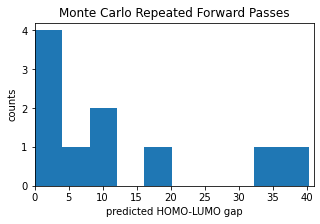

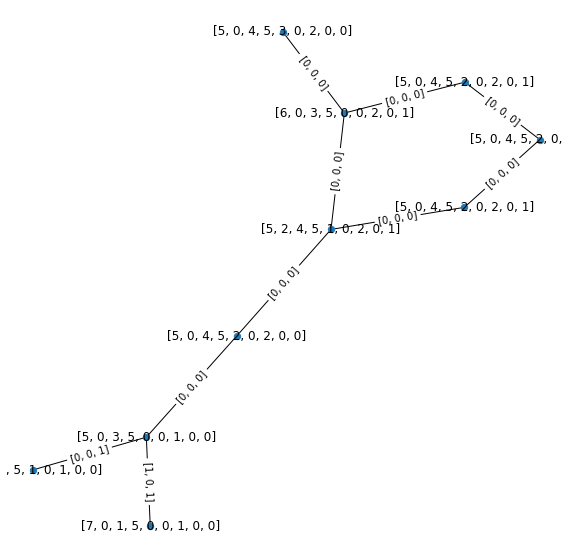

noise    10.258769
error     1.391266
Name: 61523, dtype: float64


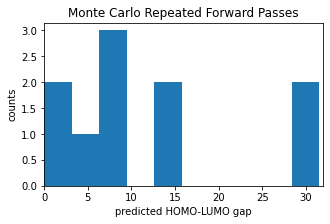

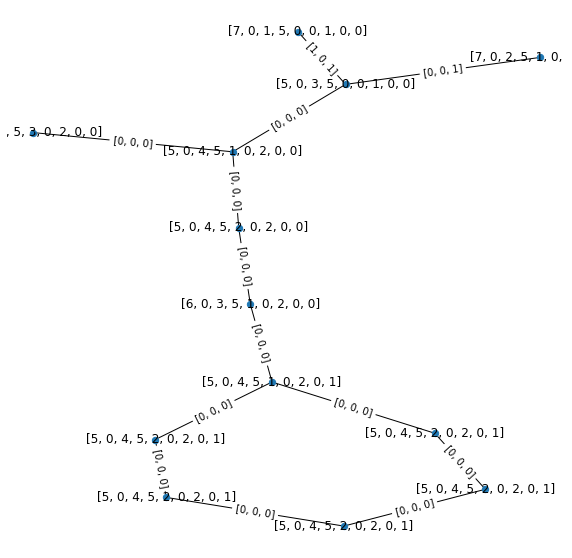

noise    14.189548
error     2.947313
Name: 100500, dtype: float64


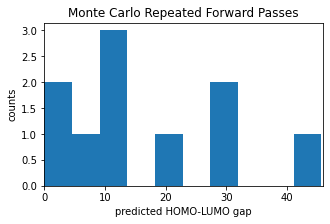

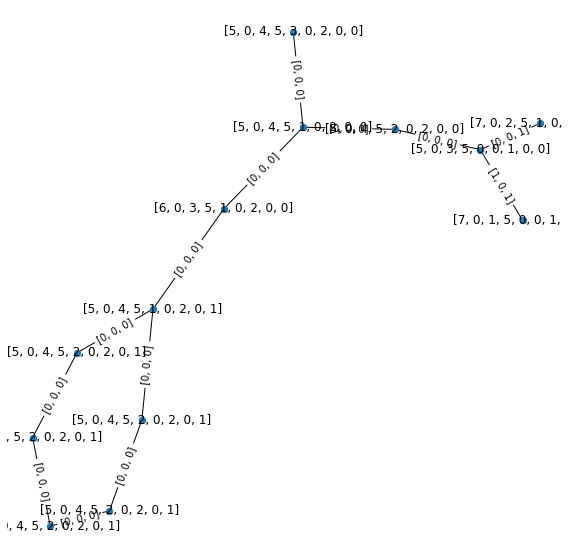

noise    11.296724
error     5.910784
Name: 102630, dtype: float64


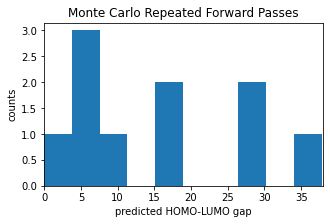

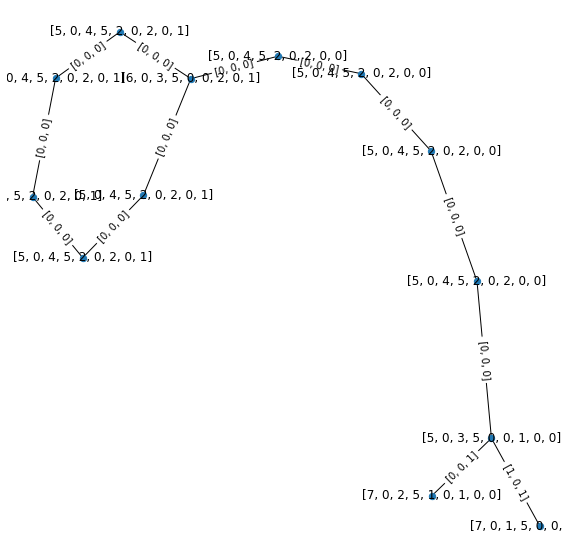

noise    10.151469
error     1.236544
Name: 102643, dtype: float64


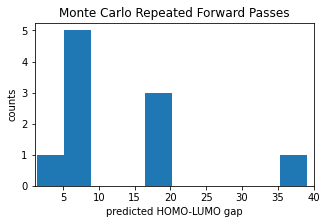

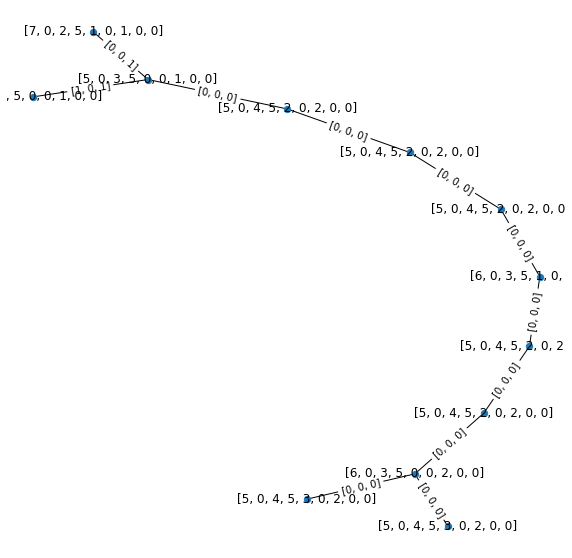

noise    11.102067
error     2.958358
Name: 150331, dtype: float64


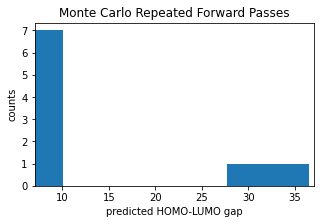

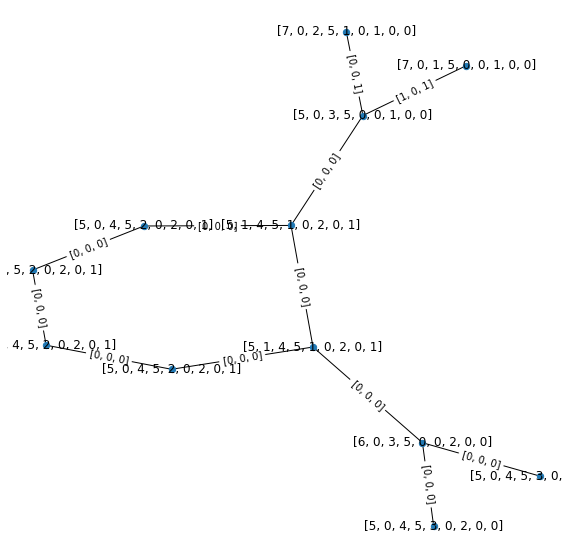

noise    19.037819
error     3.184054
Name: 187935, dtype: float64


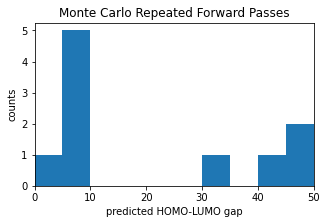

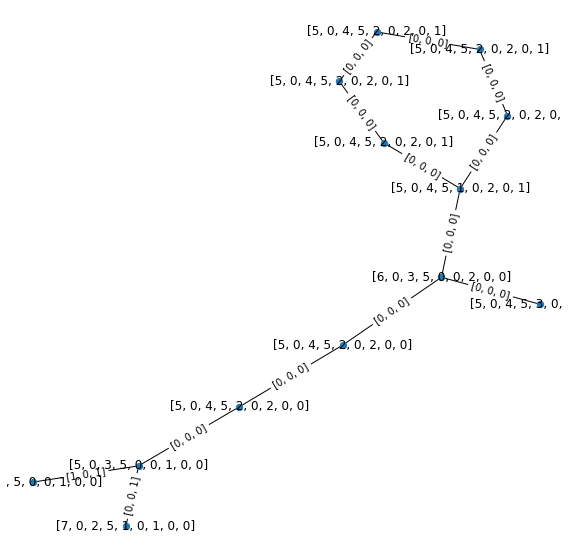

noise    12.861269
error     3.748867
Name: 187936, dtype: float64


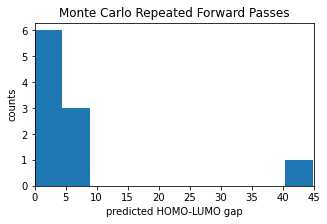

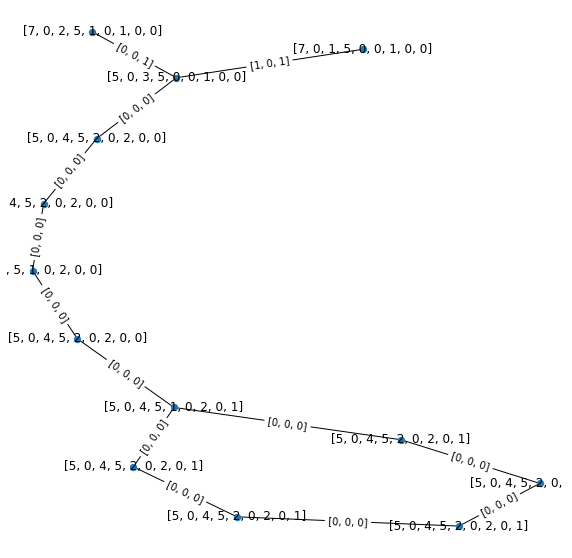

noise    12.660103
error     1.983896
Name: 193673, dtype: float64


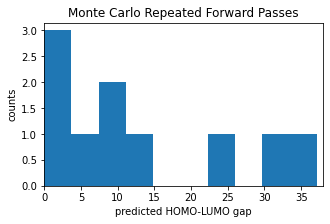

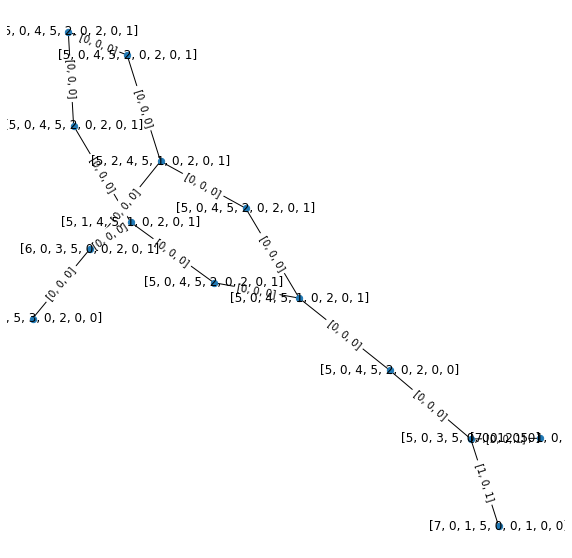

noise    10.565521
error     0.040243
Name: 308793, dtype: float64


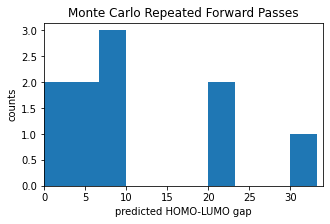

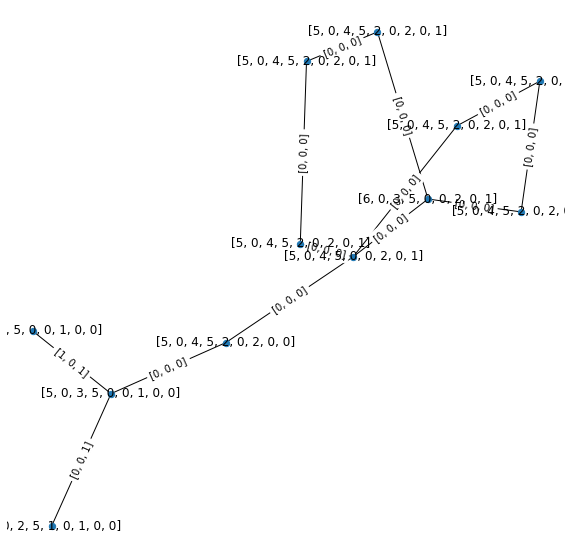

noise    13.189171
error     3.981479
Name: 325622, dtype: float64


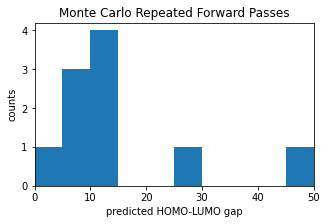

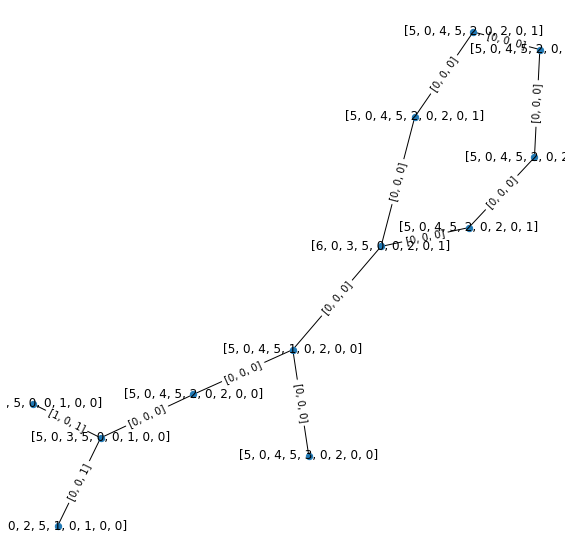

noise    16.037891
error     1.661303
Name: 333934, dtype: float64


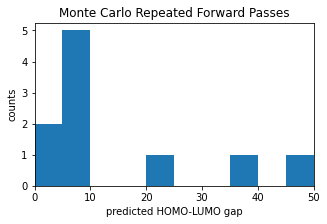

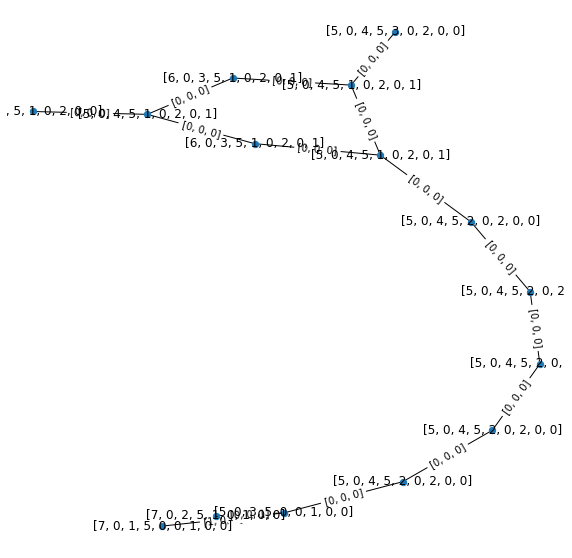

noise    11.130231
error     4.599501
Name: 357972, dtype: float64


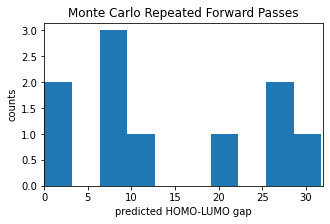

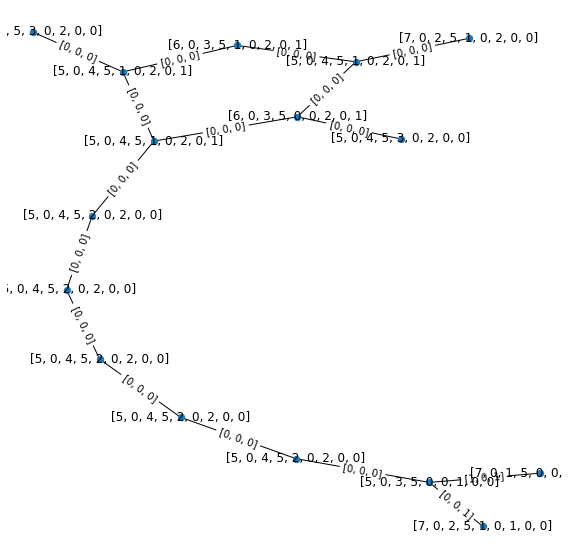

noise    11.092711
error     2.571074
Name: 364095, dtype: float64


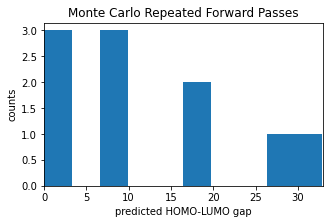

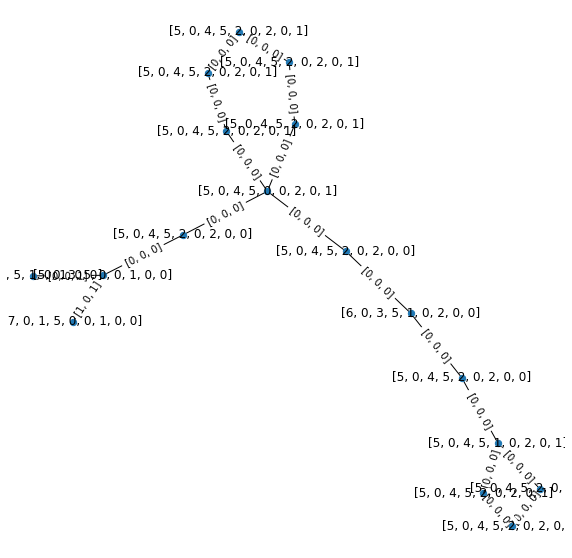

noise    11.434486
error     1.923318
Name: 364460, dtype: float64


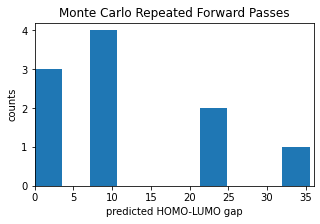

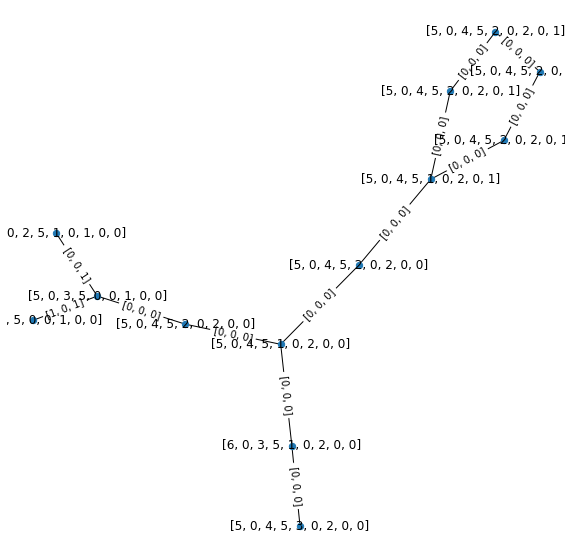

noise    10.631173
error     3.375139
Name: 366361, dtype: float64


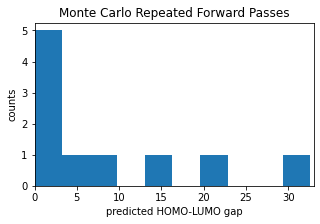

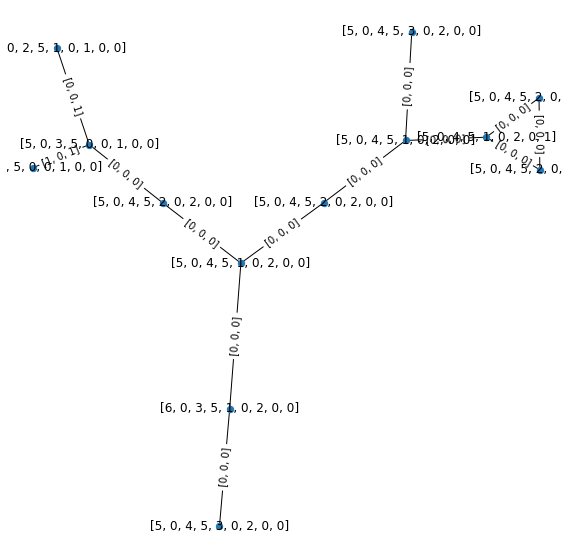

noise    11.463570
error     1.312455
Name: 376942, dtype: float64


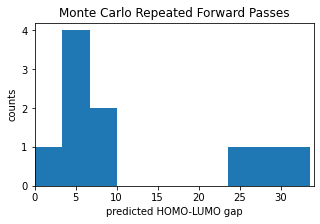

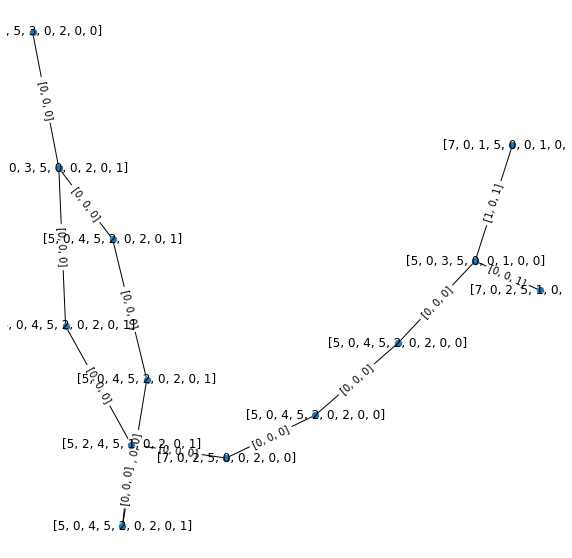

noise    13.855915
error     1.747825
Name: 376945, dtype: float64


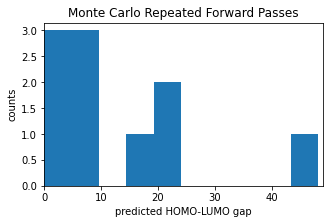

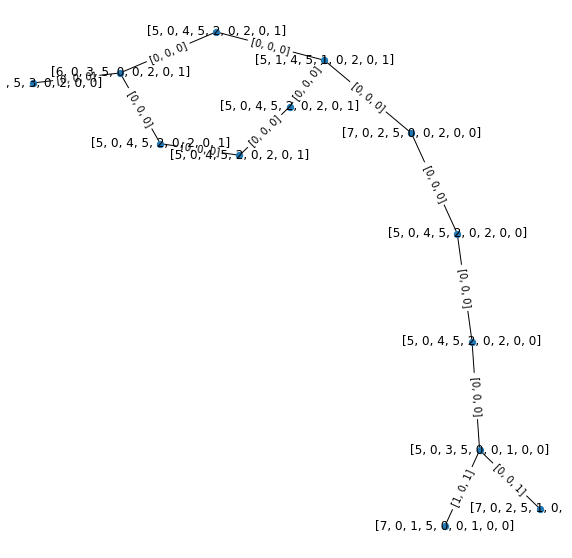

noise    10.652304
error     0.880370
Name: 376951, dtype: float64


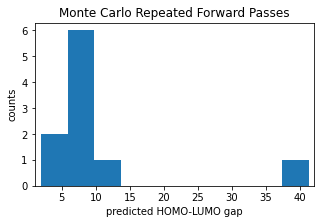

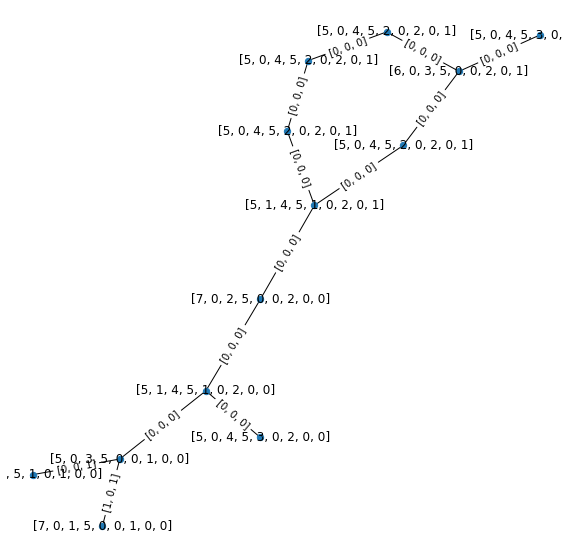

noise    0.019388
error    0.032102
Name: 161110, dtype: float64


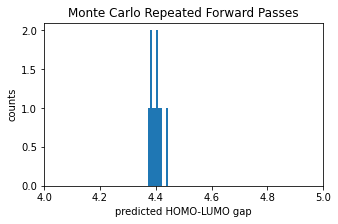

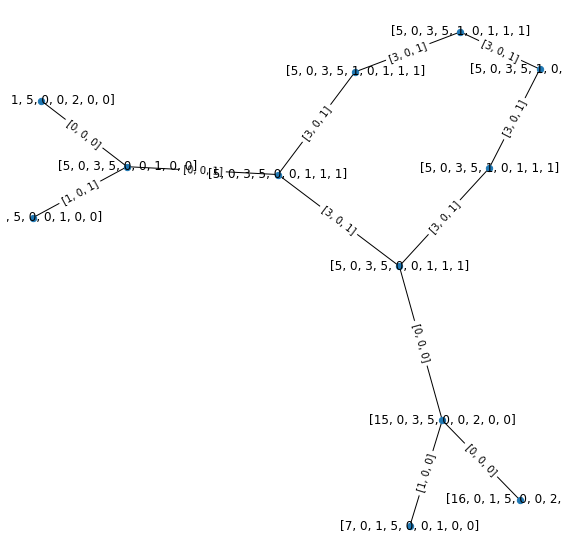

In [45]:
"""
visualise uncertain patterns
"""
for i in noiseDF[noiseDF.noise > 10].index:
    data = valid_data_list[i]
    
    print(noiseDF.loc[i])
    plt.figure(figsize=(5, 3))
    plt.hist(y_preds[:, i])
    plt.title("Monte Carlo Repeated Forward Passes")
    plt.xlabel("predicted HOMO-LUMO gap")
    plt.ylabel("counts")
#     plt.plot(y_preds[:, i])
    bot = np.floor(y_preds[:, i].min())
    up = np.ceil(y_preds[:, i].max())
    plt.xlim(bot, up)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    plotGraph(data, -1, -1, -1, ax, printnodelabel=True, printedgelabel=True, set_title=False)
    plt.show()
    
for i in noiseDF[noiseDF.noise < 0.02].index:
    data = valid_data_list[i]
    
    print(noiseDF.loc[i])
    plt.figure(figsize=(5, 3))
    plt.hist(y_preds[:, i])
#     plt.plot(y_preds[:, i])
    plt.title("Monte Carlo Repeated Forward Passes")
    plt.xlabel("predicted HOMO-LUMO gap")
    plt.ylabel("counts")
    bot = np.floor(y_preds[:, i].min())
    up = np.ceil(y_preds[:, i].max())
    plt.xlim(bot, up)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    plotGraph(data, -1, -1, -1, ax, printnodelabel=True, printedgelabel=True, set_title=False)
    plt.show()